# Runs the file containing general functions used in this script
## By default this is a file called "methane_functions.r" in the working directory of this script
## Do NOT change the working directory at any point while using this script.

In [19]:
methaneFunctions<-paste(getwd(),"/methane_functions.r",sep="")
methaneFunctions
if (file.exists(methaneFunctions)){
    source(methaneFunctions)
} else {
    print("manually correct the location and/or name of methane_functions.r")
}

[1] "/home/pleocavee/Documents/github/SensorDataProcessing/rriv_methane/methane_functions.r"

# 0. Load packages used

In [20]:
# Package names
packages<-c("dplyr", "lubridate", "ggplot2", "ggpubr")
packageHandler(packages)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




# 1. Script specific functions

## Function that takes a dataframe and pulls the last complete {sampleCount} readings from the first hour and last hour and returns them as a dataframe

In [3]:
calibration_samples<-function(df, timeCol="time.h", uuidCol="uuid", sampleCount=5){
    # get time range of dataframe
    df_range<-range(df[[timeCol]])
    
    # set first hour time frame
    first_start<-round(df_range[1], units="hours")
    first_end<-first_start+(1*60*60)
    
    # set last hour time frame
    last_end<-round(df_range[2], units="hours")
    last_start<-last_end-(1*60*60)
    
    # count number of unique devices in data frame
    uuid_count<-length( unique(df[[uuidCol]]) )
    
    # calculate total sample size to be returned per hour
    total_sample_size<-uuid_count*sampleCount 
    
    # create first hour subset
    first_hour <- df[ df[[timeCol]]>first_start & df[[timeCol]]<first_end ,]
    
    # ensure first hour has data from each device
    while( length(unique(first_hour[[uuidCol]])) != uuid_count ){
        first_start<-first_start+(1*60*60)
        first_end<-first_end+(1*60*60)
        first_hour <- df[ df[[timeCol]]>first_start & df[[timeCol]]<first_end ,]
    }
    # move to subset of last values in the hour
    first_start<-first_end-(sampleCount*60)
    
    # remake the subset and check it has sampleCount values per device
    first_hour <- df[ df[[timeCol]]>first_start & df[[timeCol]]<first_end ,]
    while ( length(first_hour[[1]]) != total_sample_size ){
        first_start <- first_start - (1*60)
        first_end <- first_end - (1*60)
        first_hour <- df[ df[[timeCol]]>first_start & df[[timeCol]]<first_end ,]
    }
    first_hour$relative_hour<-"first hour"
    
    #repeat for last_hour, TODO: combine into a loop, but switch +/- for first/last?
    last_hour <- df[ df[[timeCol]]>last_start & df[[timeCol]]<last_end ,]
    while( length(unique(last_hour[[uuidCol]])) != uuid_count ){
        last_start<-last_start-(1*60*60)
        last_end<-last_end-(1*60*60)
        last_hour <- df[ df[[timeCol]]>last_start & df[[timeCol]]<last_end ,]
    }
    last_start<-last_end-(sampleCount*60)
    last_hour <- df[ df[[timeCol]]>last_start & df[[timeCol]]<last_end ,]
    while ( length(last_hour[[1]]) != total_sample_size ){
        last_start <- last_start - (1*60)
        last_end <- last_end - (1*60)
        last_hour <- df[ df[[timeCol]]>last_start & df[[timeCol]]<last_end ,]
    }
    last_hour$relative_hour<-"last hour"
    
    # debug messages, final timestamps used
    print(first_start)
    print(first_end)
    print(last_start)
    print(last_end)
    
    # return both subsets combined
    return( rbind(first_hour, last_hour) )
}

## Function that takes a single directory and does the processing for it
1. concatenate data
2. process columns
3. subset "summary" lines
4. run those lines through calibration_samples function
5. save output to csv
6. create and save basic plots of variables vs time.h

In [4]:
extractSamples<-function(directory){
    rriv<-paste(sep="",directory,"/RRIV")
    data<-concat_dirs(rriv, read_rriv_CSV, minFileSize=300)
    data<-process_rriv_columns(data)
#     raw_data<-subset(data, type=="raw")
    summary_data<-subset(data, type=="summary")
    outputDir<-paste(rriv,"_output/",sep="")
    newDir(outputDir)

    samples<-calibration_samples(summary_data)
    ppm_tag<-gsub(".*_(.+)ppm_.*", "\\1", rriv)
    ppm_tag<-paste(ppm_tag,"ppm",sep="")
    saveDFcsv(samples,ppm_tag,od=outputDir)
    sample_plots<-plot_Data_v_Time(samples,"site")
    savePlotList(sample_plots, "sample_plots_")
}

In [6]:
# exDirectory

In [7]:
# gsub(".*a/(.+)./.*", "\\1", exDirectory)

In [8]:
# exDirectory[1]

# RUN

In [9]:
# Location of all concentration test runs
    # these are experiments that had gas samples pulled for them
directory<-"~/Desktop/data/Methane Calibration/concentration_tests"

## Get sample data from each experiment
### Sample data consists of 5 readings from both the ends of the first hour and last hour where all sensors were running

# Process every experiment at once

In [10]:
experiments<-list.dirs(directory, recursive=FALSE)
experiments

[1] "/home/pleocavee/Desktop/data/Methane Calibration/concentration_tests/20230220_1000ppm_20230221_1210"
[2] "/home/pleocavee/Desktop/data/Methane Calibration/concentration_tests/20230221_100ppm_20230222_1330" 
[3] "/home/pleocavee/Desktop/data/Methane Calibration/concentration_tests/20230222_20ppm_20230223_1130"  
[4] "/home/pleocavee/Desktop/data/Methane Calibration/concentration_tests/20230223_10ppm_202230224_1139" 
[5] "/home/pleocavee/Desktop/data/Methane Calibration/concentration_tests/20230224_5ppm_20230225_1150"   
[6] "/home/pleocavee/Desktop/data/Methane Calibration/concentration_tests/20230225_1000ppm_20230227_1115"
[7] "/home/pleocavee/Desktop/data/Methane Calibration/concentration_tests/GC"

In [11]:
# for(i in experiments){
#     rriv<-paste(sep="",i,"/RRIV")
#     if(dir.exists(rriv)){
#         extractSamples(i)
#     } else{
#         print("ERROR: RRIV folder for experiment not found")
#         break
#     }
# }

# Process a single experiment directory

In [5]:
# note: do not include final /
# exDirectory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230220_1000ppm_20230221_1210"
# exDirectory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230221_100ppm_20230222_1330"
# exDirectory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230222_20ppm_20230223_1130"
# exDirectory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230223_10ppm_202230224_1139"
# exDirectory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230224_5ppm_20230225_1150"
# exDirectory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230225_1000ppm_20230227_1115"
exDirectory<-"~/Desktop/data/Methane Calibration/concentration_tests/20230309_1000ppm_"

In [13]:
# extractSamples(exDirectory)

# code specific for 20230309_1000ppm_ experiment

In [7]:
rriv<-paste(sep="",exDirectory,"/RRIV")
data<-concat_dirs(rriv, read_rriv_CSV, minFileSize=300)
data<-process_rriv_columns(data)
summary_data<-subset(data, type=="summary")
outputDir<-paste(rriv,"_output/",sep="")
newDir(outputDir)

[1] "Dataframe generated, manually process column types if necessary"
Output directory, ~/Desktop/data/Methane Calibration/concentration_tests/20230309_1000ppm_/RRIV_output/, already exists


In [13]:
variableDict<-getDict(summary_data)

variableCount<-length(variableDict)
variableKeys<-names(variableDict)

summaryPlots<-hourlyPlotsvTime(summary_data)

Output directory, ~/Desktop/data/Methane Calibration/concentration_tests/20230309_1000ppm_/RRIV_output/hourlyPlots/, already exists


[1] "2023-03-09 18:00:25 UTC" "2023-03-10 15:16:28 UTC"

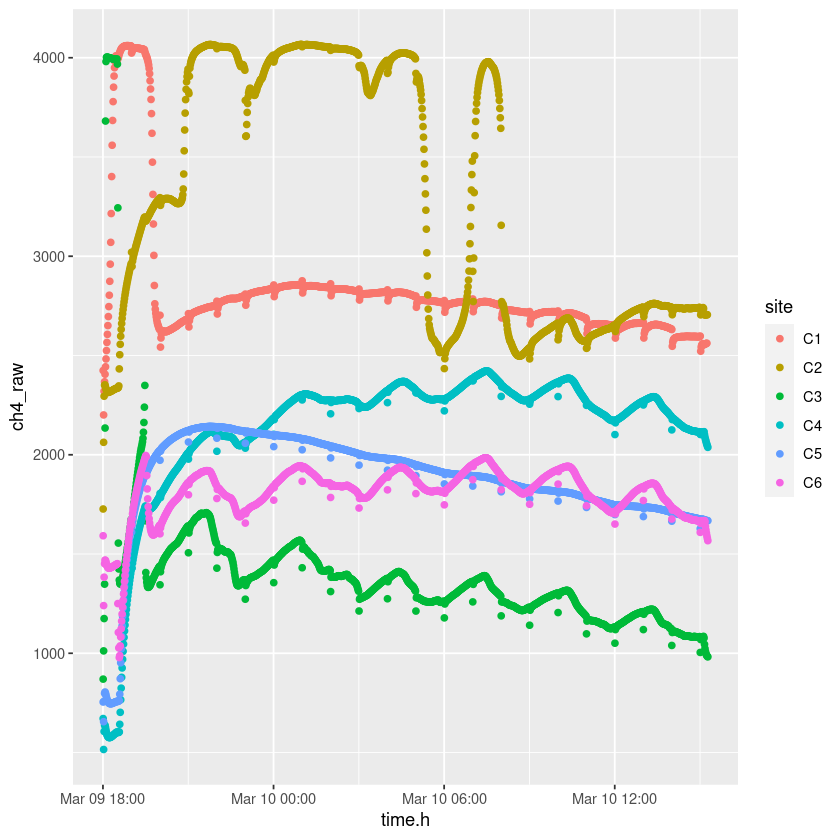

In [82]:
range(summary_data$time.h)
ggplot(summary_data,aes(x=time.h, y=ch4_raw, color=site))+geom_point()

[1] "2023-03-09 18:00:00 UTC"

[1] "2023-03-09 19:00:00 UTC"

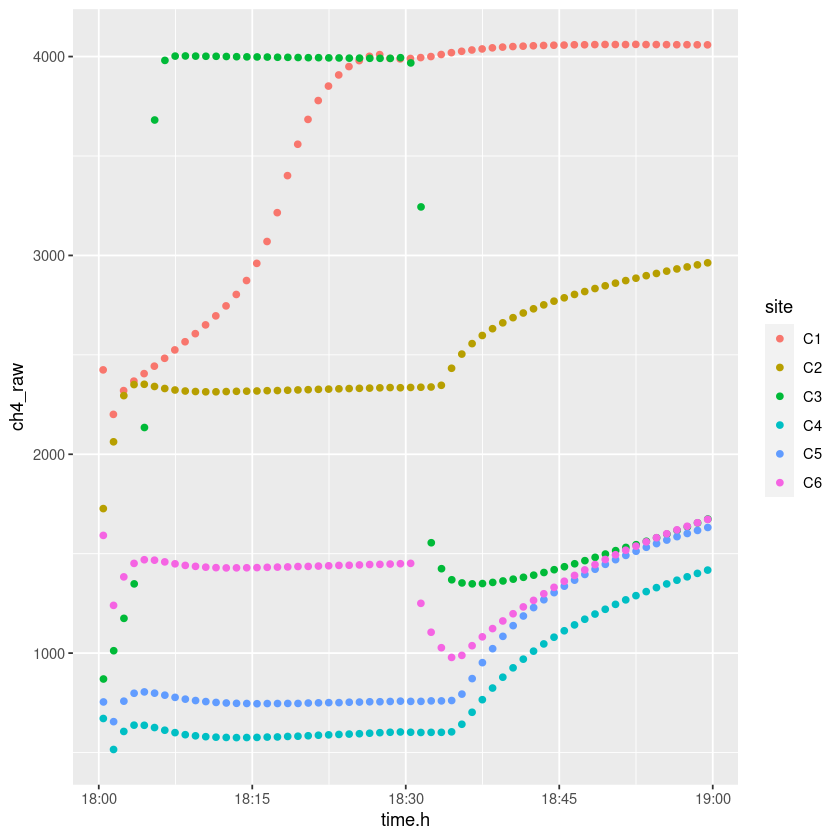

In [61]:
startTime<-round(range(summary_data$time.h)[1],"hours")
startTime
endTime<-startTime+1*60*60
endTime
firstHour<-summary_data[summary_data$time.h>startTime & summary_data$time.h<endTime,]
ggplot(firstHour,aes(x=time.h, y=ch4_raw, color=site))+geom_point()

[1] "2023-03-09 18:25:27 UTC" "2023-03-09 18:29:29 UTC"

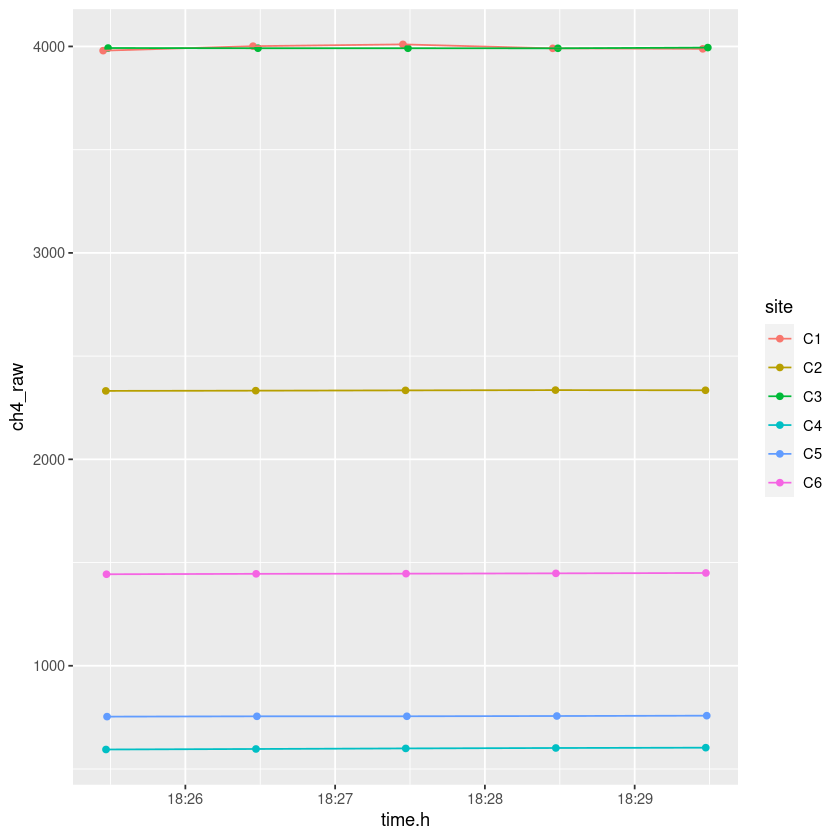

In [80]:
firstSample<-summary_data[summary_data$time.h>(startTime+25*60) & summary_data$time.h<(startTime+30*60),]
range(firstSample$time.h)
ggplot(firstSample,aes(x=time.h, y=ch4_raw, color=site))+geom_point()+geom_line()

[1] "2023-03-09 19:55:28 UTC" "2023-03-09 19:59:30 UTC"

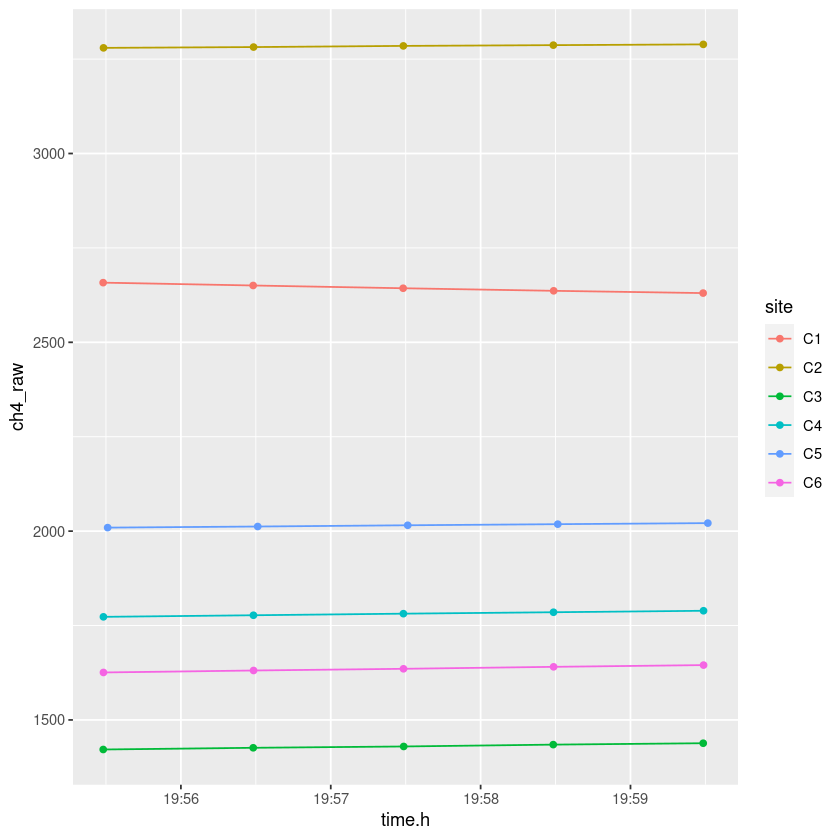

In [81]:
secondSample<-summary_data[summary_data$time.h>(startTime+1*60*60+55*60) & summary_data$time.h<(endTime+1*60*60),]
range(secondSample$time.h)
ggplot(secondSample,aes(x=time.h, y=ch4_raw, color=site))+geom_point()+geom_line()

[1] "2023-03-10 04:30:27 UTC" "2023-03-10 04:34:29 UTC"

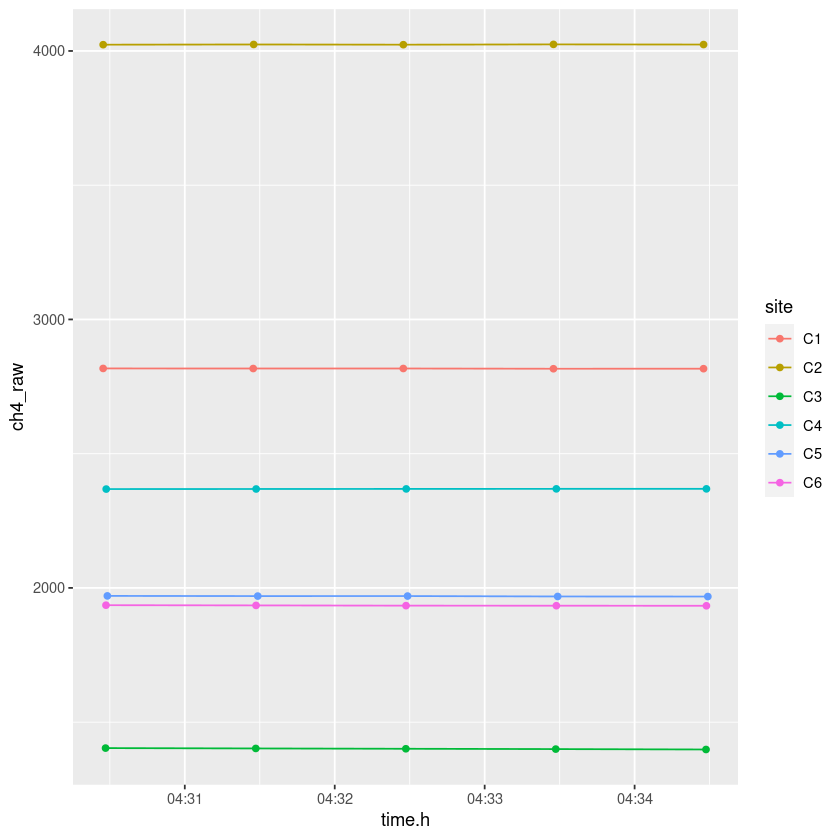

In [83]:
thirdSample<-summary_data[summary_data$time.h>(startTime+10*60*60+30*60) & summary_data$time.h<(endTime+10*60*60-25*60),]
range(thirdSample$time.h)
ggplot(thirdSample,aes(x=time.h, y=ch4_raw, color=site))+geom_point()+geom_line()

In [84]:
firstSample$relative_hour<-"first"
secondSample$relative_hour<-"first"
thirdSample$relative_hour<-"tenth"

samples<-rbind( firstSample, secondSample, thirdSample)
samples

,type,site,logger,deployment,deployed_at,uuid,time.s,time.h,battery.V,measurementCycle,burstCycle,dht_C,dht_RH,ch4rf_raw,ch4rf_cal,ch4_raw,ch4_cal,user_note,user_value,relative_hour
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<chr>
1951,summary,C1,21010,calCH001-57FF70068387575129270167-1678383565,1678383565,57FF70068387575129270167,1678386327,2023-03-09 18:25:27,1974,1,26,25.90,23.90,1968.9,0,3979.6,0,NA,NA,first
2026,summary,C1,21010,calCH001-57FF70068387575129270167-1678383565,1678383565,57FF70068387575129270167,1678386387,2023-03-09 18:26:27,2006,1,27,25.95,23.90,1969.6,0,4001.3,0,NA,NA,first
2101,summary,C1,21010,calCH001-57FF70068387575129270167-1678383565,1678383565,57FF70068387575129270167,1678386447,2023-03-09 18:27:27,2014,1,28,25.95,23.90,1969.9,0,4009.9,0,NA,NA,first
2176,summary,C1,21010,calCH001-57FF70068387575129270167-1678383565,1678383565,57FF70068387575129270167,1678386507,2023-03-09 18:28:27,1975,1,29,26.00,23.90,1970.1,0,3990.8,0,NA,NA,first
2251,summary,C1,21010,calCH001-57FF70068387575129270167-1678383565,1678383565,57FF70068387575129270167,1678386567,2023-03-09 18:29:27,1996,1,30,26.05,23.90,1971.0,0,3988.3,0,NA,NA,first
19511,summary,C2,21011,calCH002-57FF6C068387575136470767-1678383623,1678383623,57FF6C068387575136470767,1678386328,2023-03-09 18:25:28,1569,1,26,25.05,20.00,2003.0,0,2331.5,0,NA,NA,first
20261,summary,C2,21011,calCH002-57FF6C068387575136470767-1678383623,1678383623,57FF6C068387575136470767,1678386388,2023-03-09 18:26:28,1564,1,27,25.10,20.00,2003.3,0,2332.6,0,NA,NA,first
21011,summary,C2,21011,calCH002-57FF6C068387575136470767-1678383623,1678383623,57FF6C068387575136470767,1678386448,2023-03-09 18:27:28,1559,1,28,25.15,19.95,2005.0,0,2334.0,0,NA,NA,first
21761,summary,C2,21011,calCH002-57FF6C068387575136470767-1678383623,1678383623,57FF6C068387575136470767,1678386508,2023-03-09 18:28:28,1532,1,29,25.20,20.00,2004.1,0,2335.3,0,NA,NA,first


In [87]:
ppm_tag<-gsub(".*_(.+)ppm_.*", "\\1", rriv)
ppm_tag<-paste(ppm_tag,"ppm",sep="")
ppm_tag
saveDFcsv(samples,ppm_tag,od=outputDir)
sample_plots<-plot_Data_v_Time(samples,"site")
savePlotList(sample_plots, "sample_plots_")

[1] "1000ppm"

[1] "~/Desktop/data/Methane Calibration/concentration_tests/20230309_1000ppm_/RRIV_output/samples_1000ppm.csv"


In [90]:
sampleMeans<-average_ppm_runs(samples)
sampleMeans

`summarise()` has grouped output by 'site', 'deployed_at', 'measurementCycle'. You can override using the `.groups` argument.



site,deployed_at,measurementCycle,type,deployment,uuid,time.s,time.h,battery.V,ch4rf_raw,ch4rf_cal,ch4_raw,ch4_cal,dht_C,dht_RH,relative_hour
<fct>,<int>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
C1,1678383565,1,summary,calCH001-57FF70068387575129270167-1678383565,57FF70068387575129270167,1678386447,2023-03-09 18:27:27,1993.0,1969.90,0,3993.98,0,25.970,23.900,first
C1,1678383565,2,summary,calCH001-57FF70068387575129270167-1678383565,57FF70068387575129270167,1678391849,2023-03-09 19:57:29,1641.0,1979.82,0,2643.70,0,27.034,24.134,first
C1,1678383565,11,summary,calCH001-57FF70068387575129270167-1678383565,57FF70068387575129270167,1678422747,2023-03-10 04:32:27,1677.4,1973.08,0,2817.00,0,26.500,24.028,tenth
C2,1678383623,1,summary,calCH002-57FF6C068387575136470767-1678383623,57FF6C068387575136470767,1678386448,2023-03-09 18:27:28,1558.8,2004.00,0,2333.58,0,25.150,19.990,first
C2,1678383623,2,summary,calCH002-57FF6C068387575136470767-1678383623,57FF6C068387575136470767,1678391849,2023-03-09 19:57:29,1803.8,2019.68,0,3284.54,0,26.510,19.840,first
C2,1678383623,11,summary,calCH002-57FF6C068387575136470767-1678383623,57FF6C068387575136470767,1678422747,2023-03-10 04:32:27,1999.6,2013.34,0,4023.88,0,26.000,19.400,tenth
C3,1678383686,1,summary,calCH003-50FF6F068678545226521667-1678383686,50FF6F068678545226521667,1678386449,2023-03-09 18:27:29,1983.8,2116.72,0,3992.04,0,23.790,27.190,first
C3,1678383686,2,summary,calCH003-50FF6F068678545226521667-1678383686,50FF6F068678545226521667,1678391849,2023-03-09 19:57:29,1300.0,2129.94,0,1430.10,0,25.044,27.536,first
C3,1678383686,11,summary,calCH003-50FF6F068678545226521667-1678383686,50FF6F068678545226521667,1678422748,2023-03-10 04:32:28,1285.0,2124.06,0,1400.86,0,24.610,27.600,tenth


# 4 hours of data

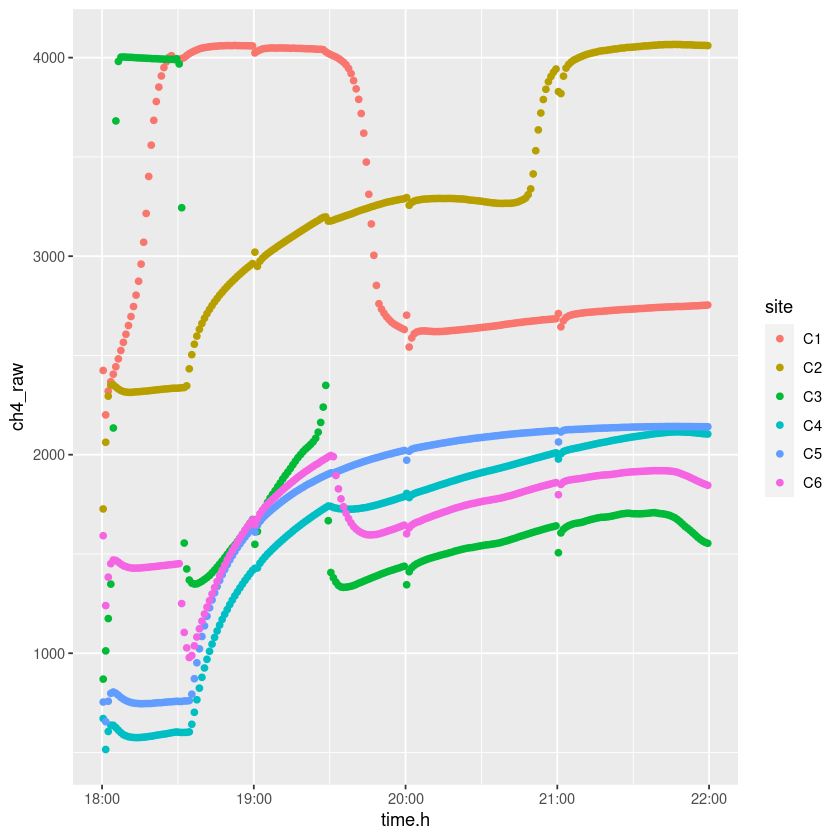

In [69]:
ggplot(summary_data[summary_data$time.h>(startTime) & summary_data$time.h<(endTime+3*60*60),],aes(x=time.h, y=ch4_raw, color=site))+geom_point()

## Concatenate all sampled data

In [14]:
# filePattern<-"samples(.+).csv"
# Files<-list.files(path=directory, recursive=TRUE, pattern=filePattern, full.names=TRUE)
# Files

sample_data<-concat_dirs(directory,read_rriv_CSV,filePattern="samples(.+).csv")
sample_data<-process_rriv_columns(sample_data)

[1] "Dataframe generated, manually process column types if necessary"


## save to csv (for visual inspection)

In [15]:
saveDFcsv(sample_data,tag ="allExperiments", paste(directory,"/",sep=""))

[1] "~/Desktop/data/Methane Calibration/concentration_tests/sample_data_allExperiments.csv"


In [16]:
# head(sample_data)

# average data for each 5 readings, which can be achieved by grouping by one of the ID columns, measurement cycle, and deployment or deployed_at column

In [89]:
average_ppm_runs<-function(df){
    grouped <- group_by(df, site, deployed_at, measurementCycle)
    means <- summarise(grouped,
                       type=type,
                       site=site,
                       deployment=deployment,
                       deployed_at=deployed_at,
                       uuid=uuid,
                       time.s=mean(time.s),
                       time.h=mean(time.h),
                       battery.V=mean(battery.V),
                       ch4rf_raw=mean(ch4rf_raw),
                       ch4rf_cal=mean(ch4rf_cal),
                       ch4_raw=mean(ch4_raw),
                       ch4_cal=mean(ch4_cal),
                       dht_C=mean(dht_C),
                       dht_RH=mean(dht_RH),
#                        ch4_ppm=mean(ch4_ppm)
                       relative_hour=relative_hour
                      )
    return(unique(means))
}

In [18]:
# str(sample_data)
class(sample_data$time.h)

[1] "POSIXct" "POSIXt"

In [19]:
sampleMeans<-average_ppm_runs(sample_data)
sampleMeans

`summarise()` has grouped output by 'site', 'deployed_at', 'measurementCycle'. You can override using the `.groups` argument.



site,deployed_at,measurementCycle,type,deployment,uuid,time.s,time.h,battery.V,ch4rf_raw,ch4rf_cal,ch4_raw,ch4_cal,dht_C,dht_RH,relative_hour
<fct>,<int>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
C1,1676933668,1,summary,calCH001-57FF70068387575129270167-1676933668,57FF70068387575129270167,1676937450,2023-02-20 23:57:29,1440.2,1979.56,0,1927.38,0,25.052,23.992,first hour
C1,1676933668,18,summary,calCH001-57FF70068387575129270167-1676933668,57FF70068387575129270167,1676998649,2023-02-21 16:57:28,1367.2,1982.76,0,1597.38,0,25.400,23.100,last hour
C1,1677016047,1,summary,calCH001-57FF70068387575129270167-1677016047,57FF70068387575129270167,1677020251,2023-02-21 22:57:30,1263.8,1979.56,0,1454.20,0,22.820,23.280,first hour
C1,1677016047,20,summary,calCH001-57FF70068387575129270167-1677016047,57FF70068387575129270167,1677088649,2023-02-22 17:57:28,1315.8,1983.04,0,1538.94,0,23.100,23.710,last hour
C1,1677096098,1,summary,calCH001-57FF70068387575129270167-1677096098,57FF70068387575129270167,1677103050,2023-02-22 21:57:29,1282.6,1951.88,0,1270.92,0,22.934,22.000,first hour
C1,1677096098,19,summary,calCH001-57FF70068387575129270167-1677096098,57FF70068387575129270167,1677167849,2023-02-23 15:57:28,1335.4,1957.62,0,1498.82,0,23.570,22.080,last hour
C1,1677177835,1,summary,calCH001-57FF70068387575129270167-1677177835,57FF70068387575129270167,1677182250,2023-02-23 19:57:29,1248.4,1981.06,0,1177.90,0,22.708,24.318,first hour
C1,1677177835,22,summary,calCH001-57FF70068387575129270167-1677177835,57FF70068387575129270167,1677256348,2023-02-24 16:32:28,1364.0,1986.46,0,1485.48,0,23.190,24.800,last hour
C1,1677274787,1,summary,calCH001-57FF70068387575129270167-1677274787,57FF70068387575129270167,1677279450,2023-02-24 22:57:29,1259.0,1950.62,0,1234.24,0,23.960,21.500,first hour


## calculate absolute humidity

In [91]:
sampleMeans<-calcAbsoluteHumidity(sampleMeans)
head(sampleMeans)

# df<-sampleMeans
# df$dht_K<-df$dht_C+273.15

# #determine water vapor saturation point (https://www.orslabs.fr/pdf/Humidity%20Equations.pdf)
# P<-1013.25 #millibar, standard pressure ~1 atmosphere
# df$ews_mbar<-(1.0007+3.46*10^-6*P)*6.1121^(17.502*df$dht_C/(240.9+df$dht_C))
# df$ews_kPa<-df$ews_mbar/10

# #convert relative humidity to molar PPM (https://www.learnthermo.com/examples/ch02/p-2d-9.php)
# # note: assuming 1 atmosphere, 101.325 kPa, and volume of 1
# df$H2O_mol<-df$dht_RH*df$ews_kPa/101.325
# df$BDA_mol<-1-df$H2O_mol #mass of dry air

# MW_H2O<-18.01528
# MW_BDA<-28.97

# df$MW_gas<-df$BDA_mol*MW_BDA+df$H2O_mol*MW_H2O


# #vaisala absolute humidity equation (https://www.hatchability.com/Vaisala.pdf)
# C<-2.16679 #gK/J
# # df$aH_gm3<-C*df$PH2O_kPa*(df$dht_RH/100)*1000/(273.15+df$dht_C)
# df$aH_gm3<-C*df$ews_kPa*(df$dht_RH/100)*1000/(273.15+df$dht_C)

# head(df)
# sampleMeans<-df

site,deployed_at,measurementCycle,type,deployment,uuid,time.s,time.h,battery.V,ch4rf_raw,⋯,dht_C,dht_RH,relative_hour,dht_K,ews_mbar,ews_kPa,H2O_mol,BDA_mol,MW_gas,aH_gm3
<fct>,<int>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C1,1678383565,1,summary,calCH001-57FF70068387575129270167-1678383565,57FF70068387575129270167,1678386447,2023-03-09 18:27:27,1993.0,1969.90,⋯,25.970,23.900,first,299.120,21.92020,2.192020,0.5170420,0.4829580,23.30595,3.795018
C1,1678383565,2,summary,calCH001-57FF70068387575129270167-1678383565,57FF70068387575129270167,1678391849,2023-03-09 19:57:29,1641.0,1979.82,⋯,27.034,24.134,first,300.184,24.55667,2.455667,0.5849007,0.4150993,22.56258,4.277874
C1,1678383565,11,summary,calCH001-57FF70068387575129270167-1678383565,57FF70068387575129270167,1678422747,2023-03-10 04:32:27,1677.4,1973.08,⋯,26.500,24.028,tenth,299.650,23.19868,2.319868,0.5501287,0.4498713,22.94349,4.030728
C2,1678383623,1,summary,calCH002-57FF6C068387575136470767-1678383623,57FF6C068387575136470767,1678386448,2023-03-09 18:27:28,1558.8,2004.00,⋯,25.150,19.990,first,298.300,20.07067,2.007067,0.3959661,0.6040339,24.63230,2.914326
C2,1678383623,2,summary,calCH002-57FF6C068387575136470767-1678383623,57FF6C068387575136470767,1678391849,2023-03-09 19:57:29,1803.8,2019.68,⋯,26.510,19.840,first,299.660,23.22346,2.322346,0.4547283,0.5452717,23.98858,3.331629
C2,1678383623,11,summary,calCH002-57FF6C068387575136470767-1678383623,57FF6C068387575136470767,1678422747,2023-03-10 04:32:27,1999.6,2013.34,⋯,26.000,19.400,tenth,299.150,21.99078,2.199078,0.4210423,0.5789577,24.35760,3.090083


In [ ]:
# # input RRIV data with temperature in C and relative humidity
# calcAbsoluteHumidity<-function(df, celsius="dht_C", relativeHumidity="dht_RH"){
#     #determine water vapor saturation point (https://www.orslabs.fr/pdf/Humidity%20Equations.pdf)
#     P<-1013.25 #millibar, standard pressure ~1 atmosphere
# #     df$ews_mbar<-(1.0007+3.46*10^-6*P)*6.1121^(17.502*df$dht_C/(240.9+df$dht_C))
#     df$ews_mbar<-(1.0007+3.46*10^-6*P)*6.1121^(17.502*df$dht_C/(240.9+df[[celsius]]))
#     df$ews_kPa<-df$ews_mbar/10

#     #vaisala absolute humidity equation (https://www.hatchability.com/Vaisala.pdf)
#     C<-2.16679 #gK/J
# #     df$aH_gm3<-C*df$ews_kPa*(df$dht_RH/100)*1000/(273.15+df$dht_C)
#     df$aH_gm3<-C*df$ews_kPa*(df[[relativeHumidity]]/100)*1000/(273.15+df[[celsius]])

#     return(df)
# }

## Save results to csv

In [21]:
saveDFcsv(sampleMeans,od=paste(directory,"/",sep=""))

[1] "~/Desktop/data/Methane Calibration/concentration_tests/sampleMeans.csv"


In [92]:
saveDFcsv(sampleMeans,od=paste(exDirectory,"/",sep=""))

[1] "~/Desktop/data/Methane Calibration/concentration_tests/20230309_1000ppm_/sampleMeans.csv"


# Basic plots

In [93]:
variableDict<-getDict(sampleMeans)

# variableDict<-append(variableDict,c("aH_gm3"="Absolute Humidity (g/m^3)"))

variableCount<-length(variableDict)
variableKeys<-names(variableDict)

variableDict

battery.V 
                     "Battery Digital\nReading (12bit)" 
                                                  dht_C 
                                   "\nTemperature (°C)" 
                                                 dht_RH 
                              "\nRelative Humidity (%)" 
                                              ch4rf_raw 
       "Raw Methane Reference\nDigital Reading (12bit)" 
                                              ch4rf_cal 
"Calibrated Methane Reference\nDigital Reading (12bit)" 
                                                ch4_raw 
                 "Raw Methane Digital\nReading (12bit)" 
                                                ch4_cal 
          "Calibrated Methane Digital\nReading (12bit)" 
                                                 aH_gm3 
                            "Absolute Humidity (g/m^3)"

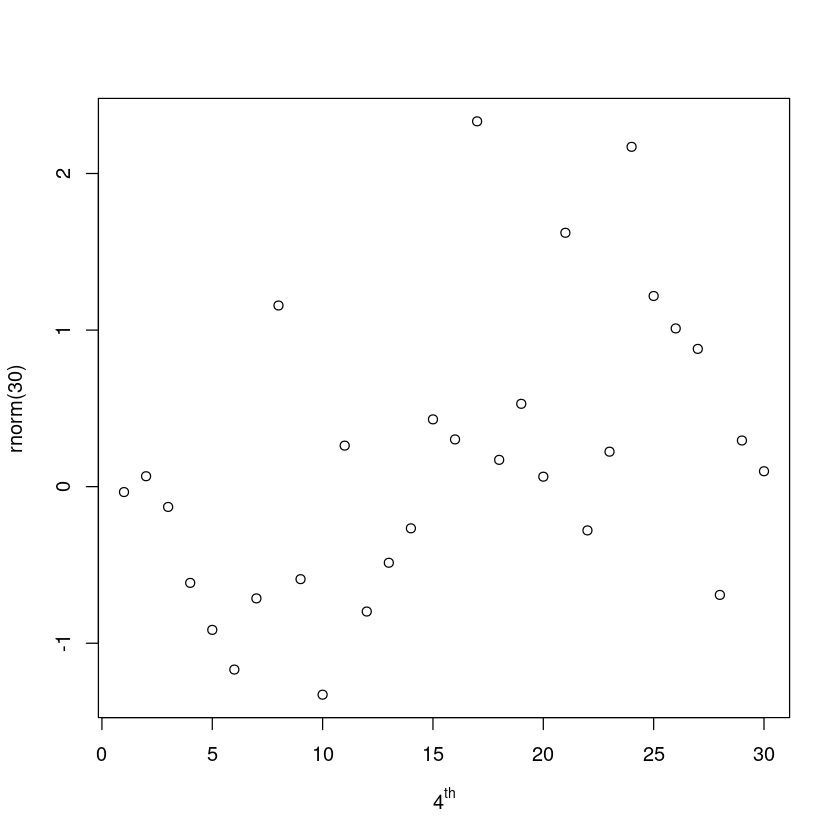

In [23]:
# examples of labels with exponents?
# parse(text='70^o*N')
test<-expression(paste("4"^"th"))
plot(rnorm(30), xlab = test)

In [24]:
plot_Data_v_Time_2 <-function(df, color="logger", timeCol="time.h", vd=variableDict, vk=variableKeys, vc=variableCount){
  # initialize list to hold plots
  DvT = vector('list', vc)
  names(DvT) = names(vd)
  
  # plot each column vs time with all deployments into list
  for ( i in 1:vc ){
    DvT[[i]] = ggplot(data=df,aes_string(x=timeCol,y=vk[i],color=color),size=1)+
      geom_point()+theme_classic(base_size=12)+
      labs(x="Date", y=vd[i], color=NULL)
    # +
    #   scale_color_manual(values=custom_colors2,na.translate=F)+
    #   scale_x_datetime(date_labels="%m/%d %H",breaks=scales::pretty_breaks(n=4),expand=c(0,60*5))
  }
  return(DvT)
}

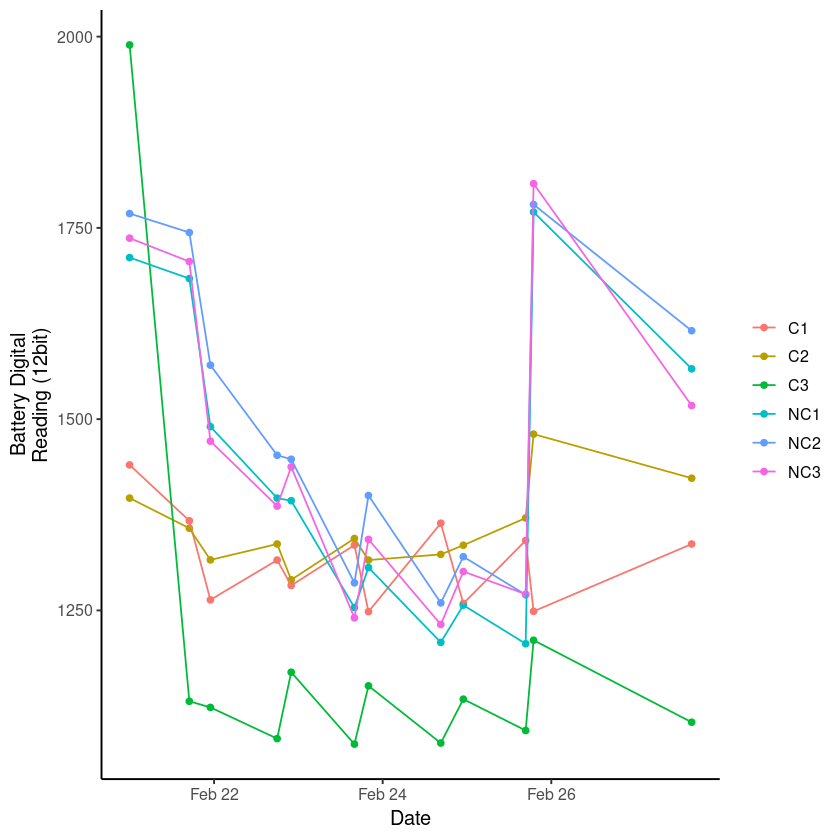

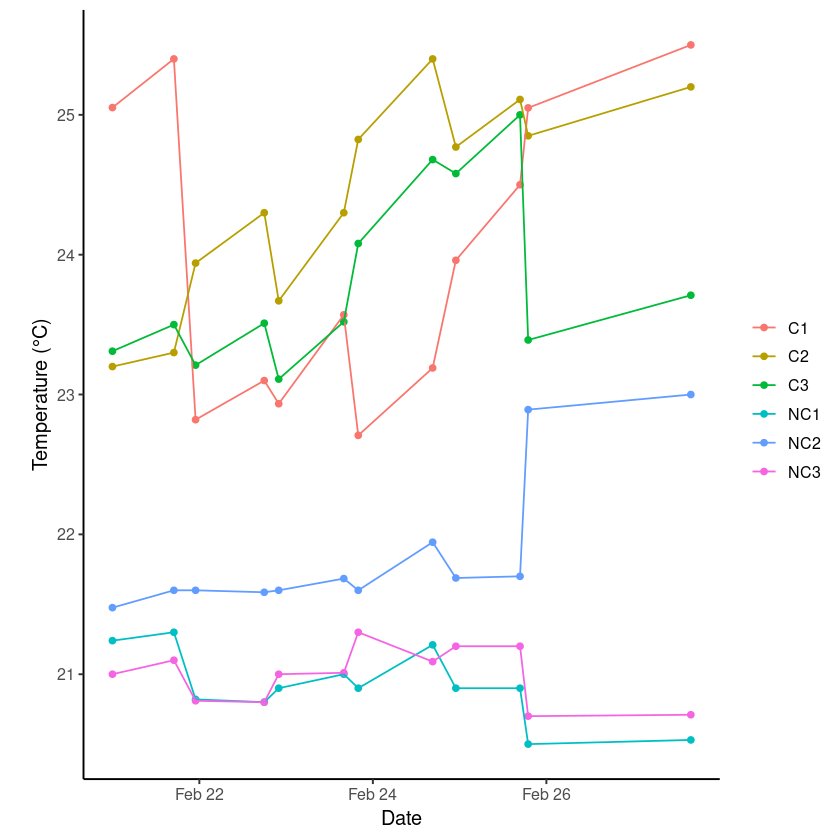

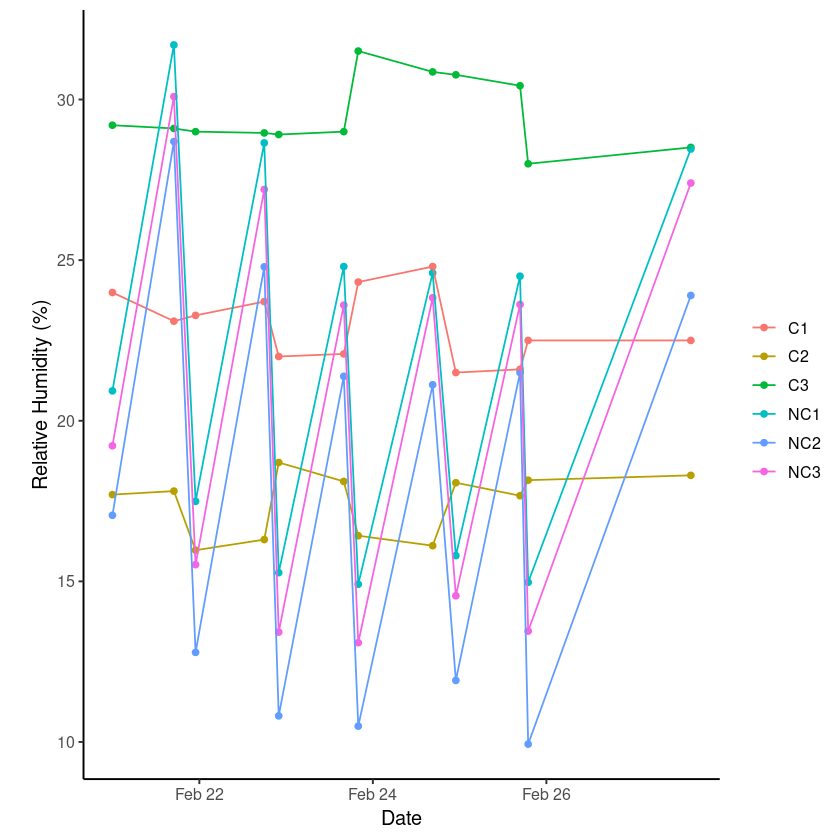

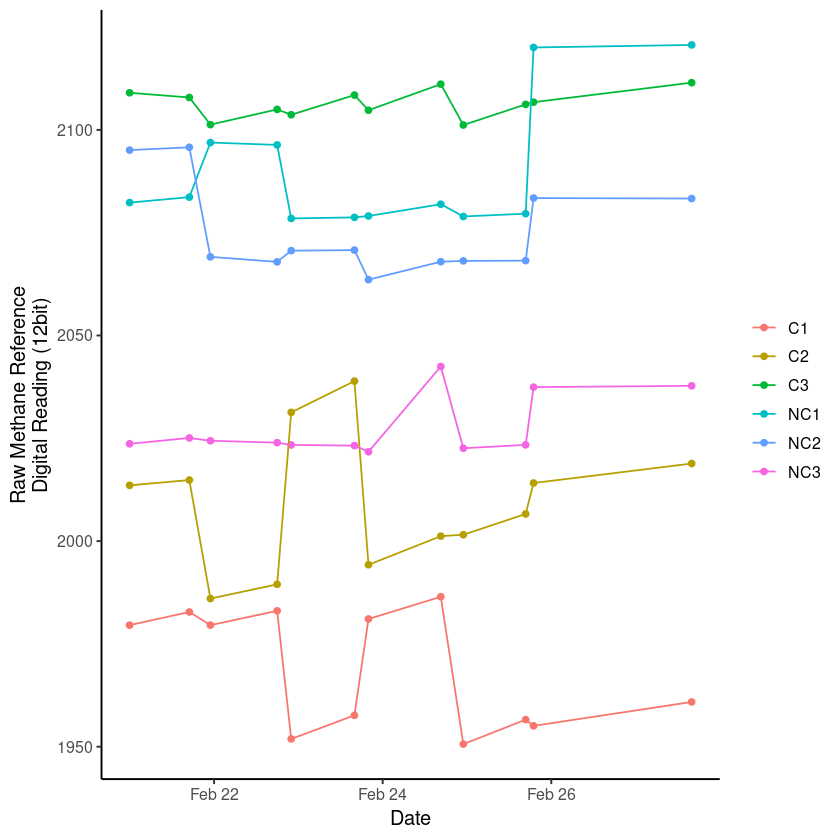

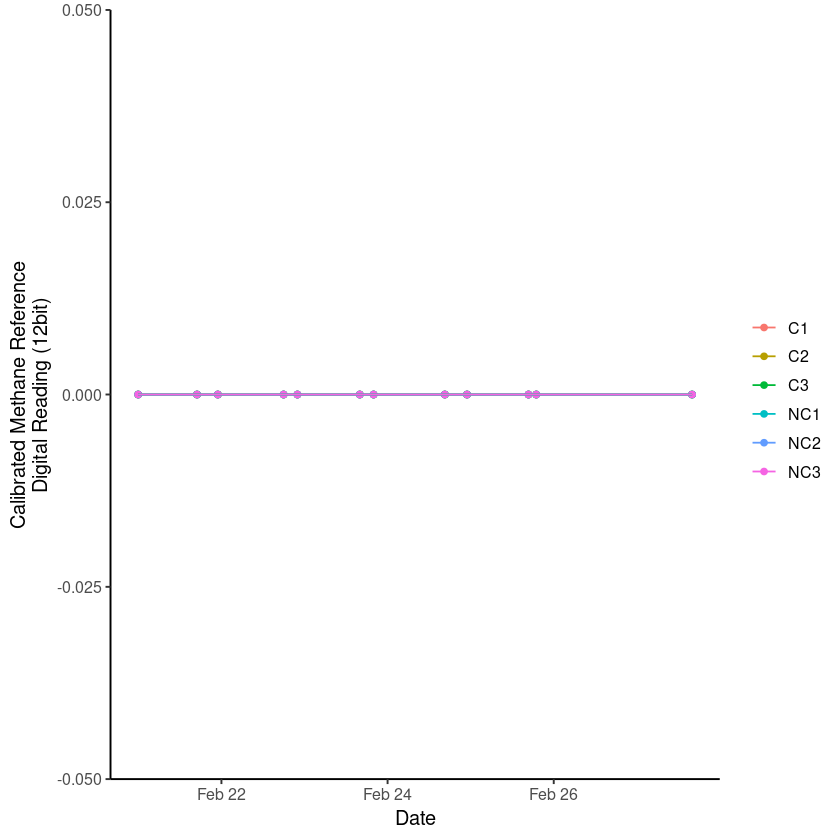

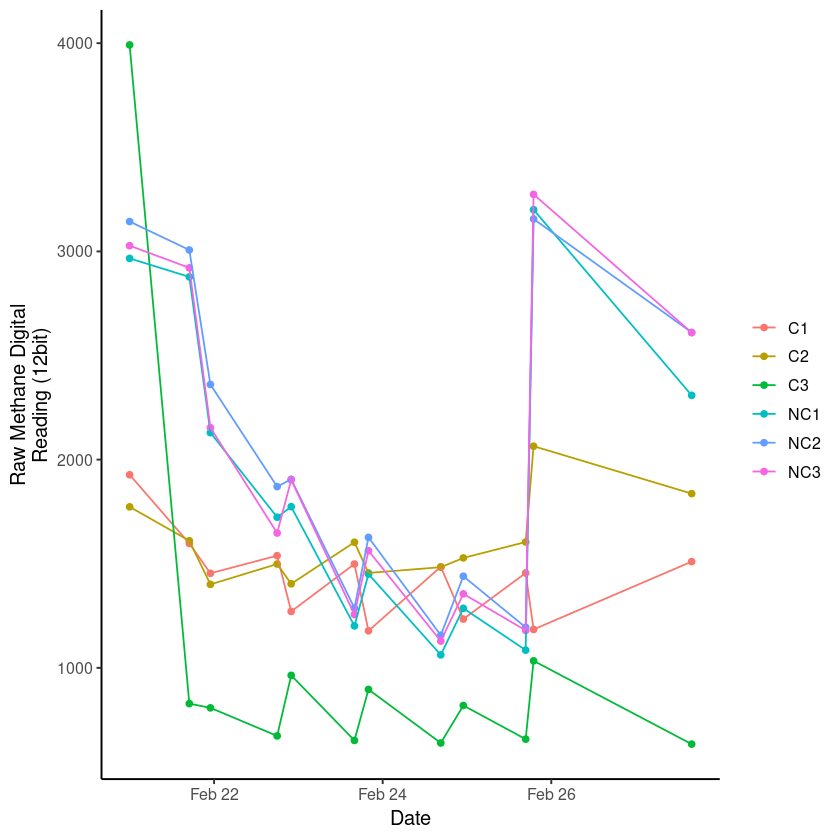

$battery.V

$dht_C

$dht_RH

$ch4rf_raw

$ch4rf_cal

$ch4_raw

$ch4_cal

$aH_gm3


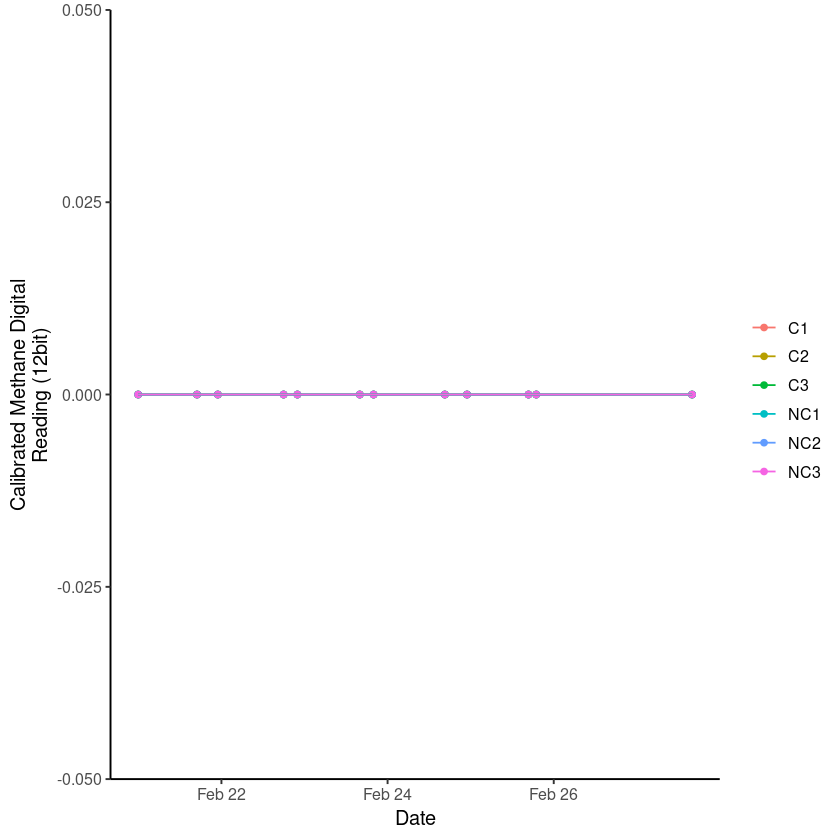

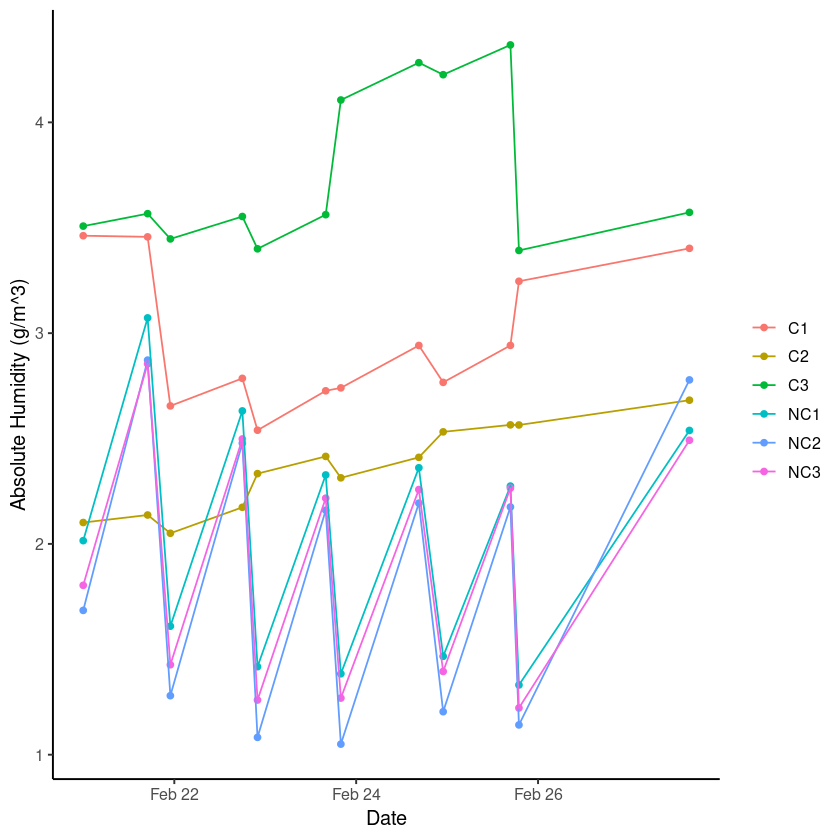

In [29]:
sampleMeans_plots<-plot_Data_v_Time(sampleMeans,color="site")
sampleMeans_plots

savePlotList(sampleMeans_plots,tag="FirstLast", od=paste(directory,"/",sep=""))

In [26]:
# str(sampleMeans)
first_hour_sM<-sampleMeans[sampleMeans$relative_hour == "first hour",]
last_hour_sM<-sampleMeans[sampleMeans$relative_hour == "last hour",]

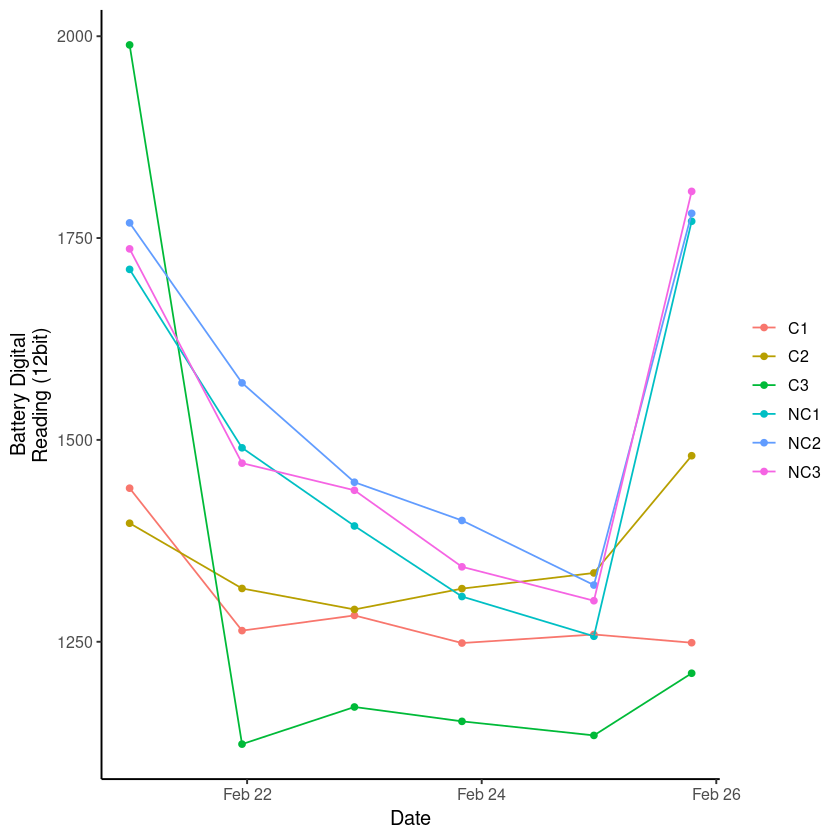

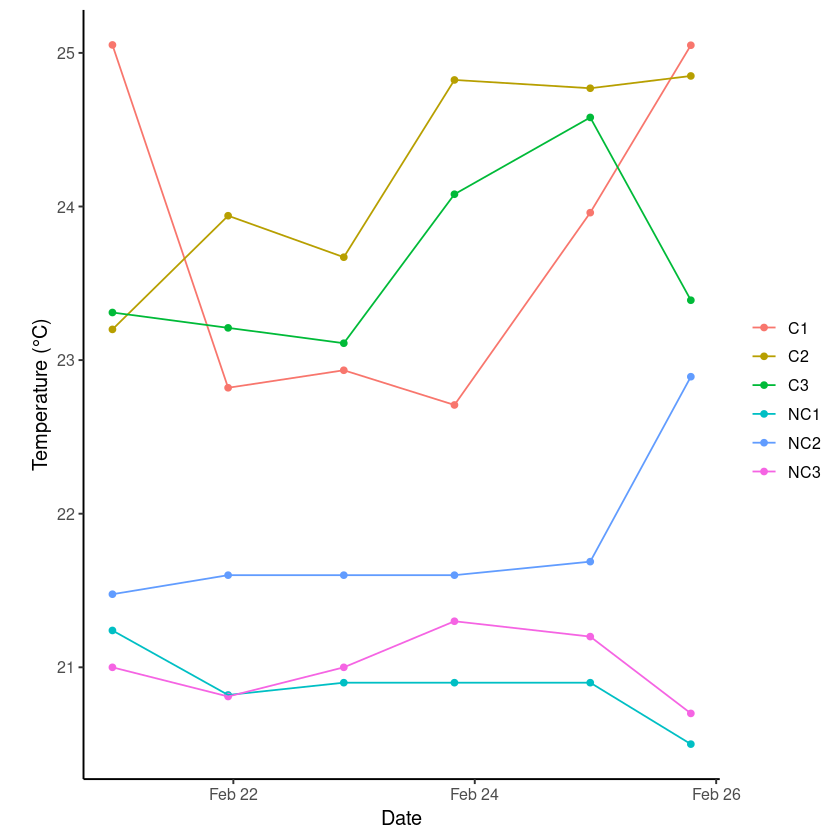

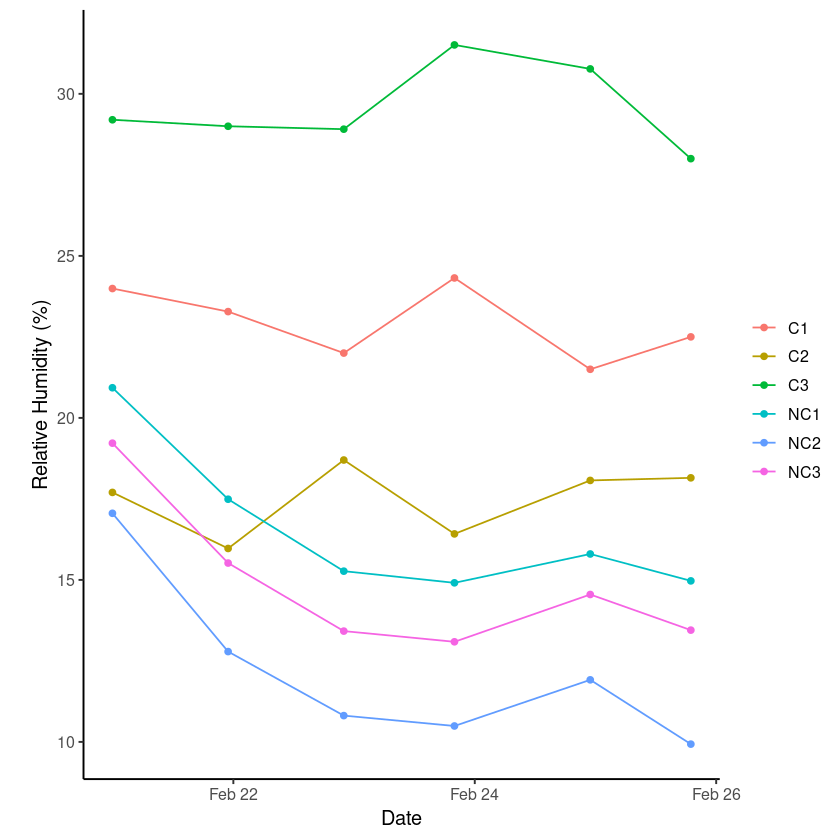

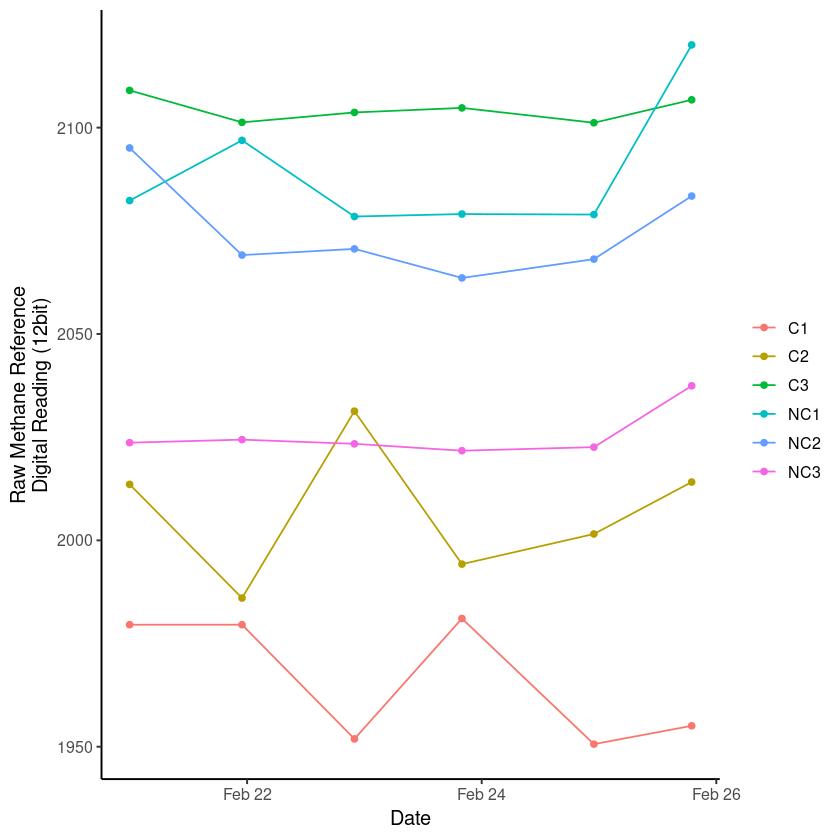

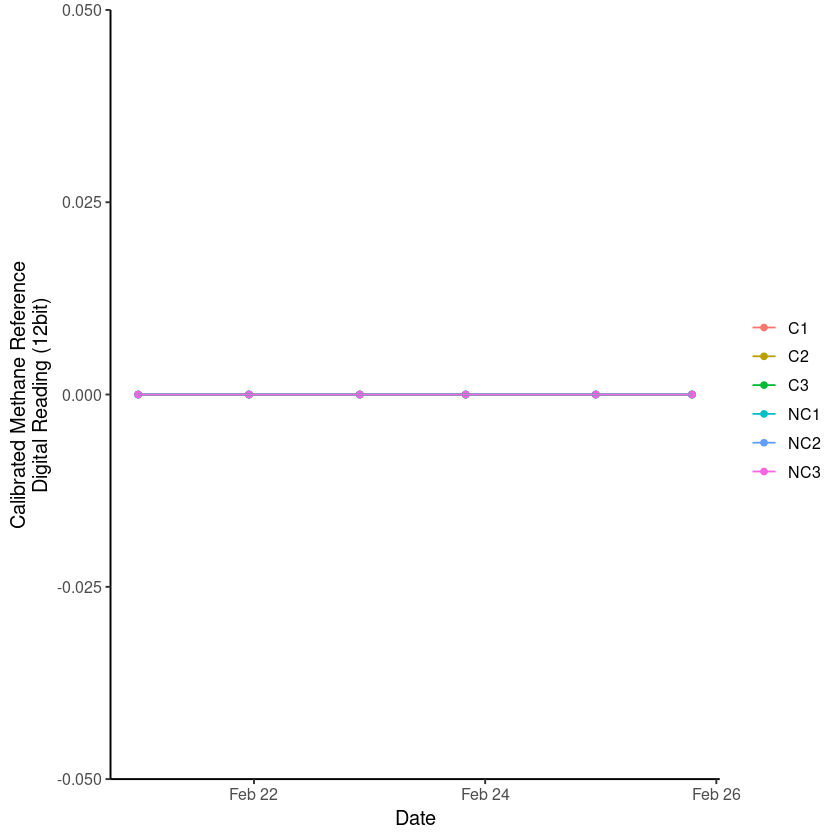

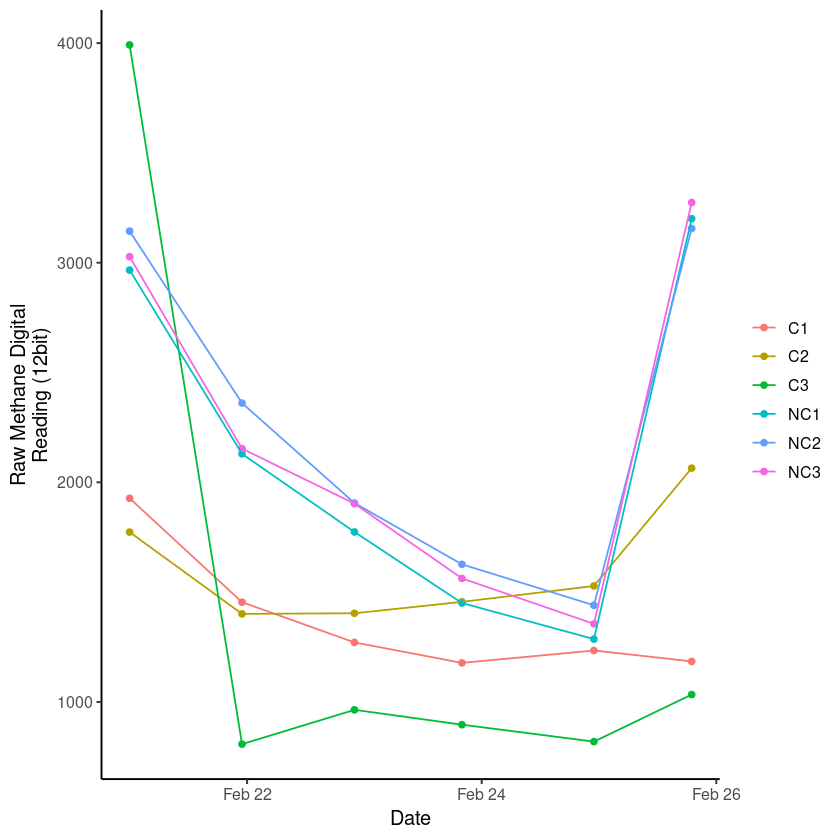

$battery.V

$dht_C

$dht_RH

$ch4rf_raw

$ch4rf_cal

$ch4_raw

$ch4_cal

$aH_gm3


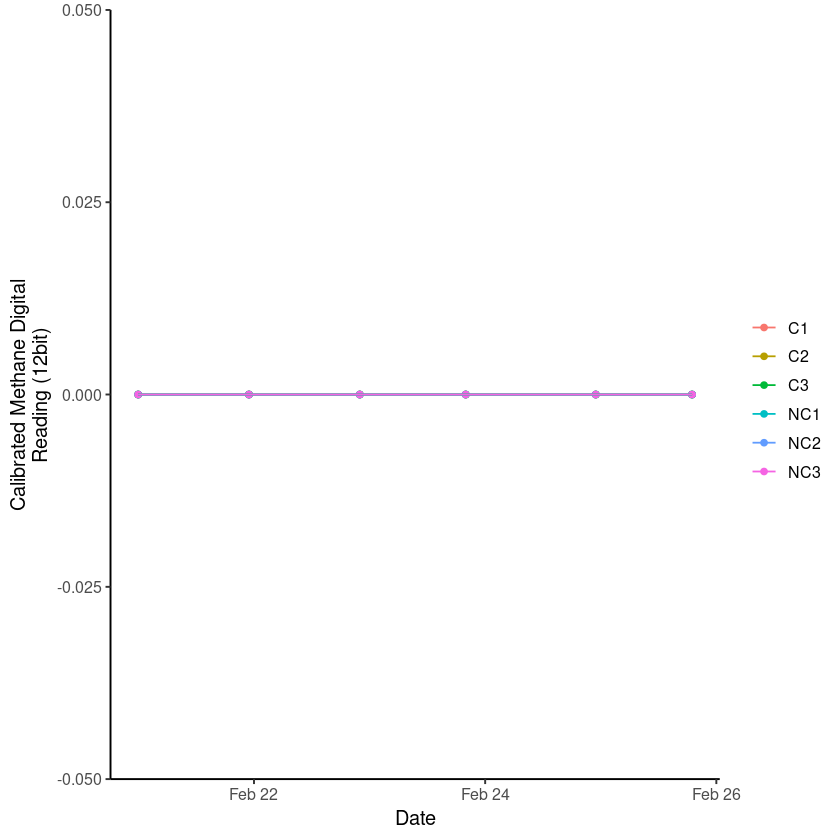

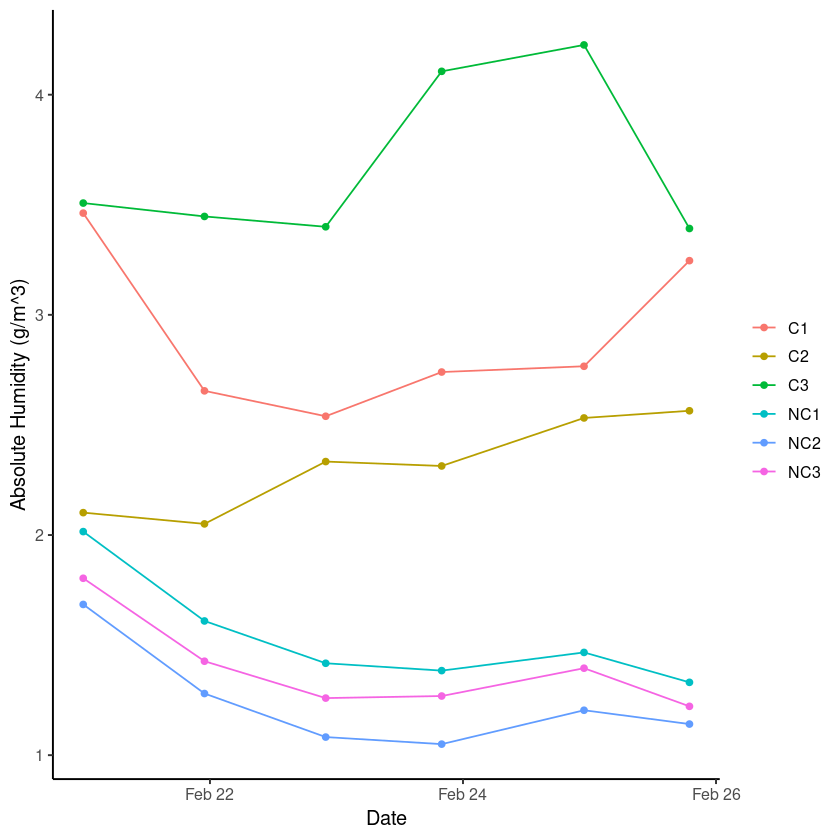

In [30]:
sampleMeans_first_plots<-plot_Data_v_Time(first_hour_sM,color="site")
sampleMeans_first_plots

savePlotList(sampleMeans_first_plots,tag="First", od=paste(directory,"/",sep=""))

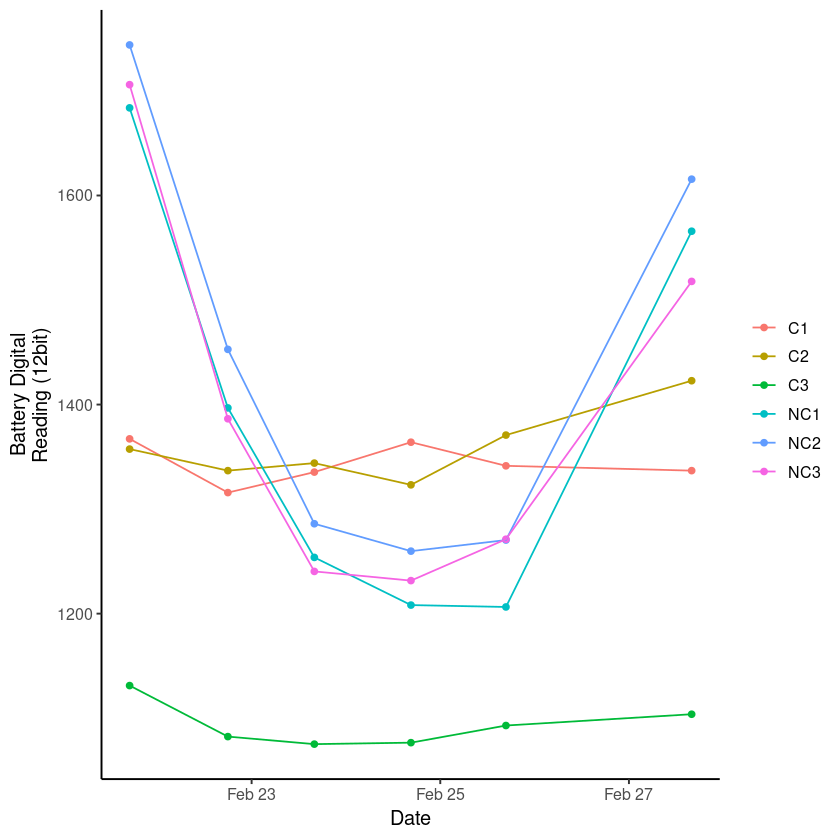

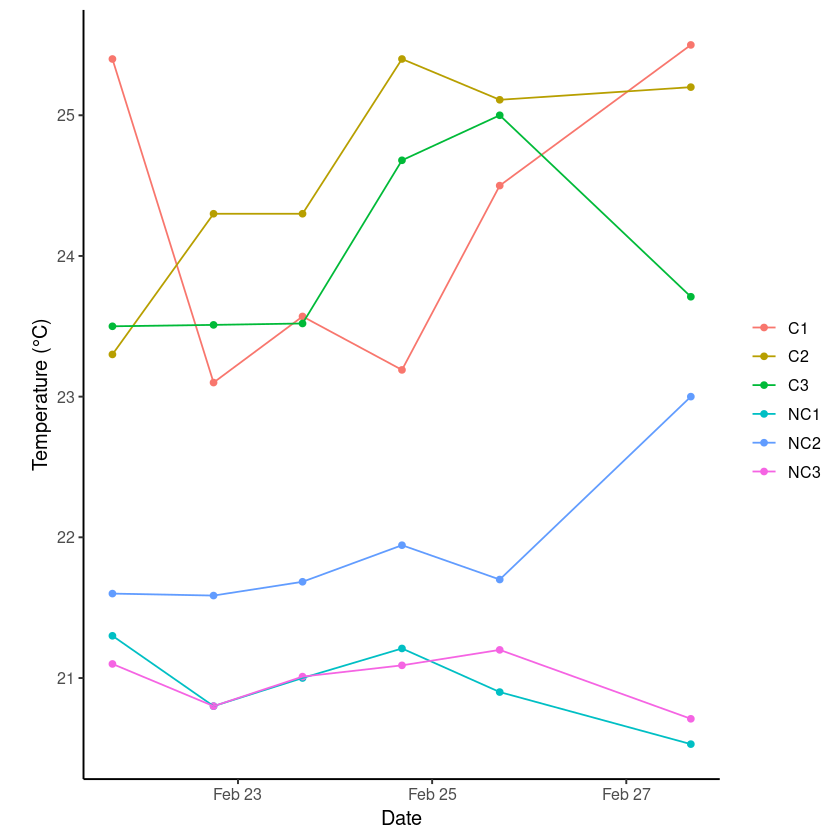

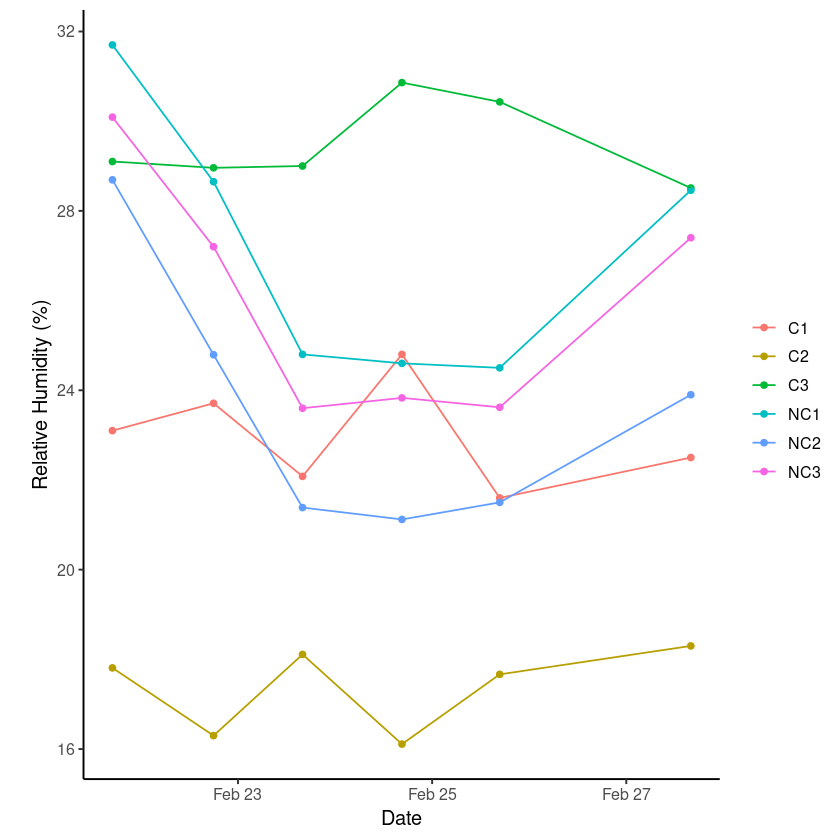

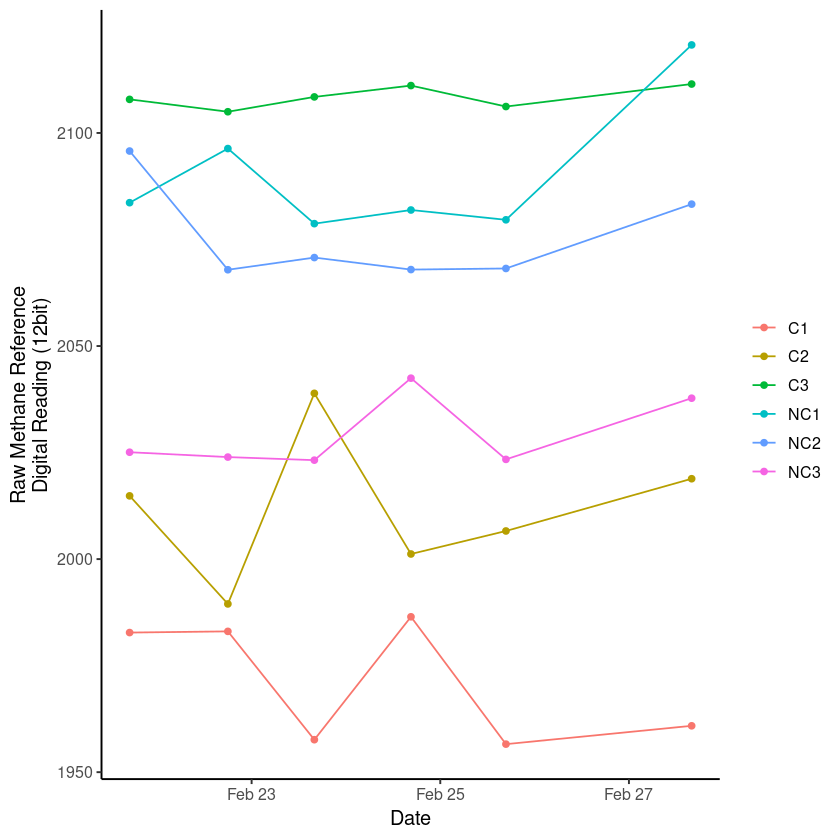

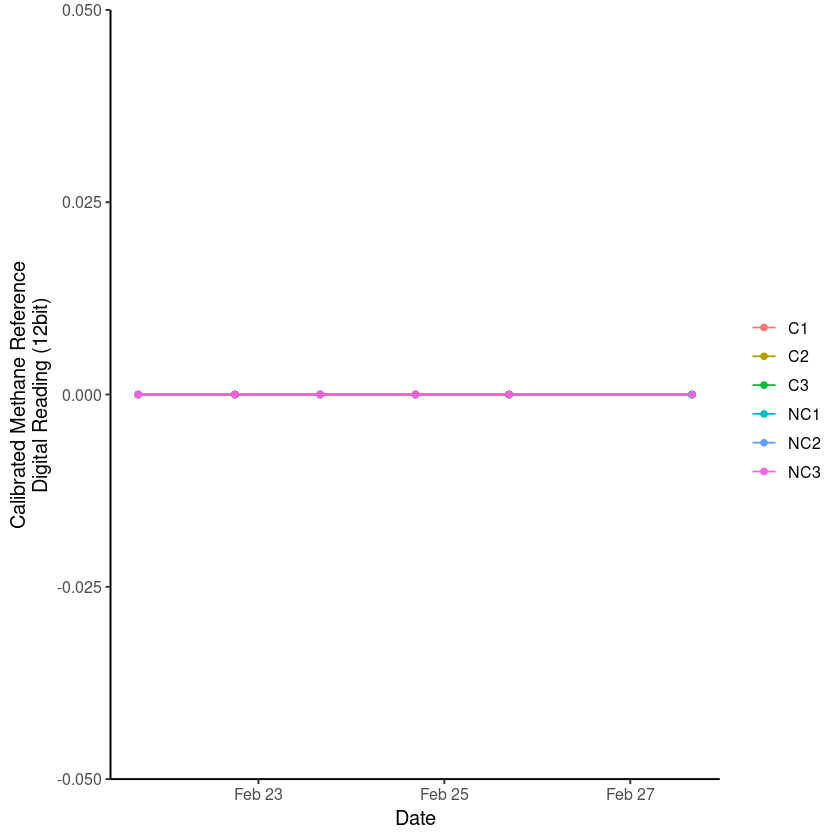

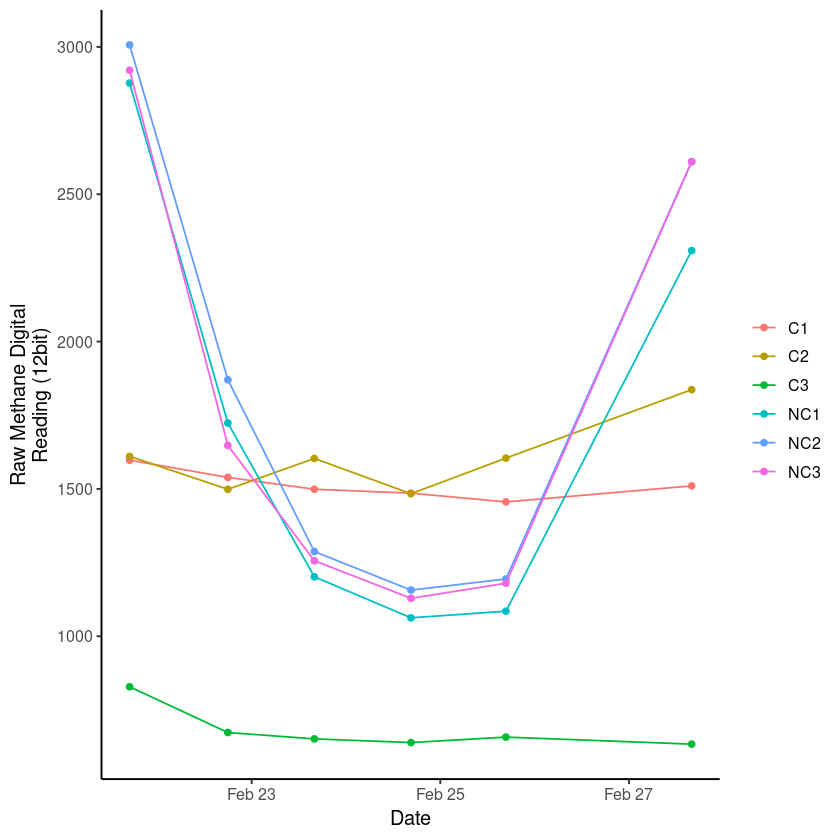

$battery.V

$dht_C

$dht_RH

$ch4rf_raw

$ch4rf_cal

$ch4_raw

$ch4_cal

$aH_gm3


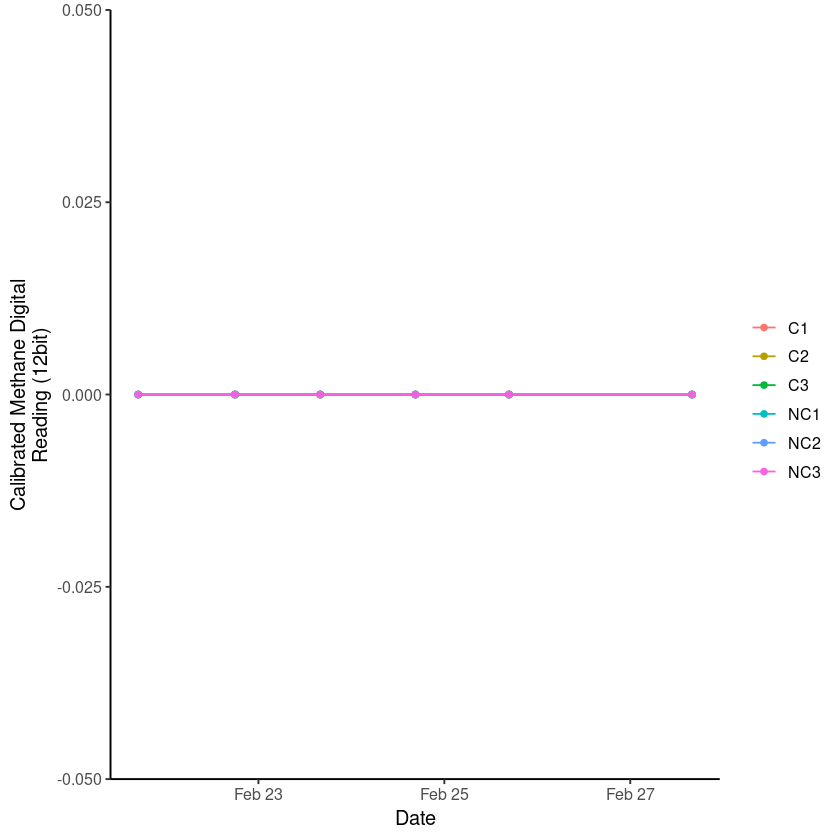

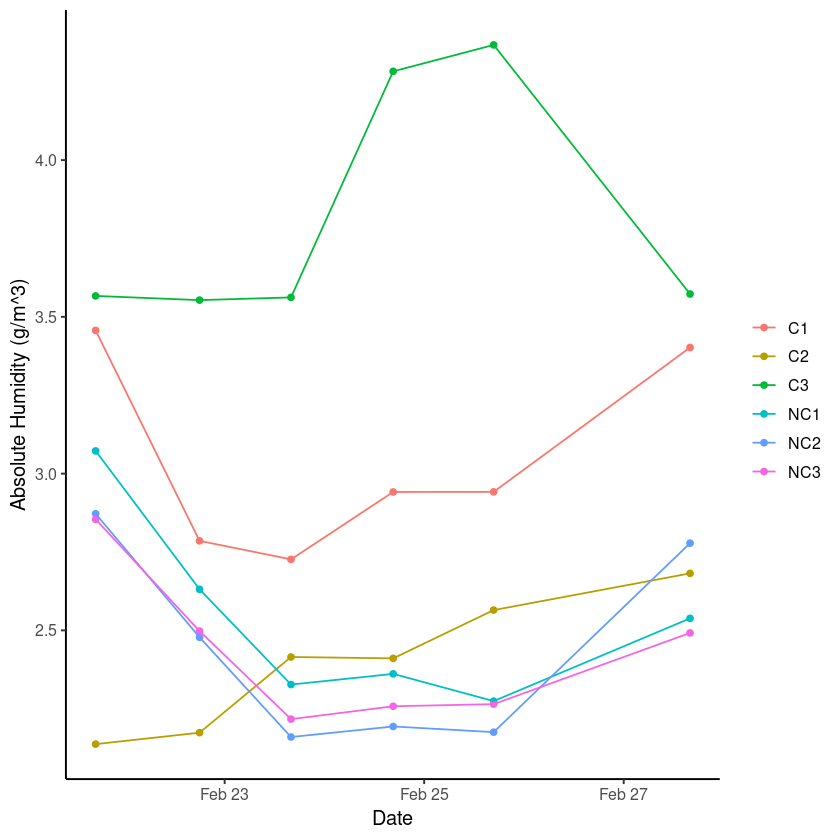

In [31]:
sampleMeans_last_plots<-plot_Data_v_Time(last_hour_sM,color="site")
sampleMeans_last_plots

savePlotList(sampleMeans_last_plots,tag="Last", od=paste(directory,"/",sep=""))

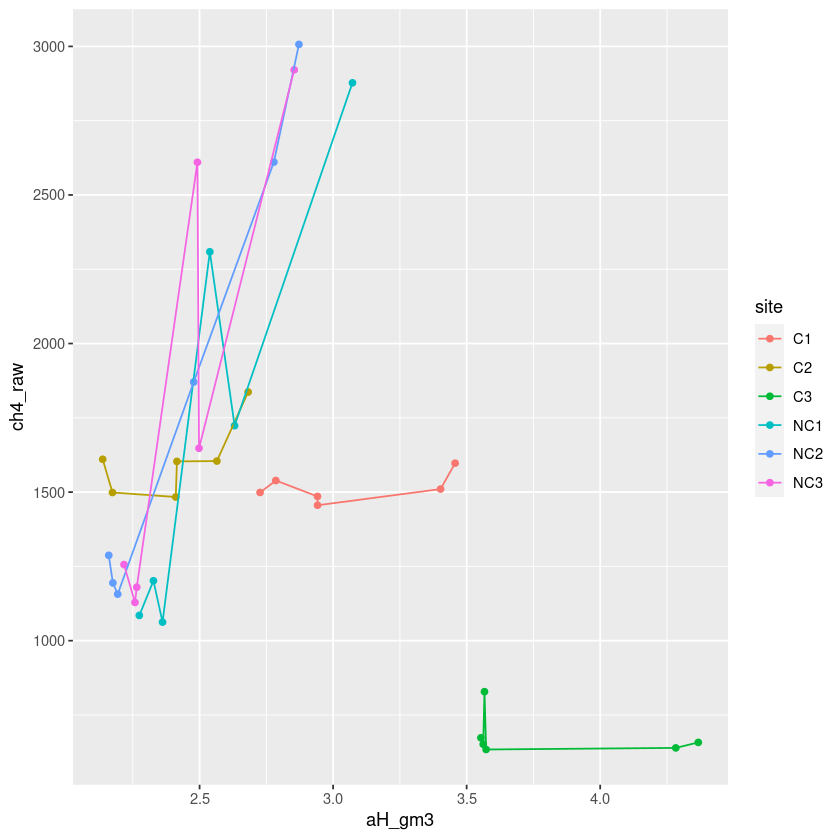

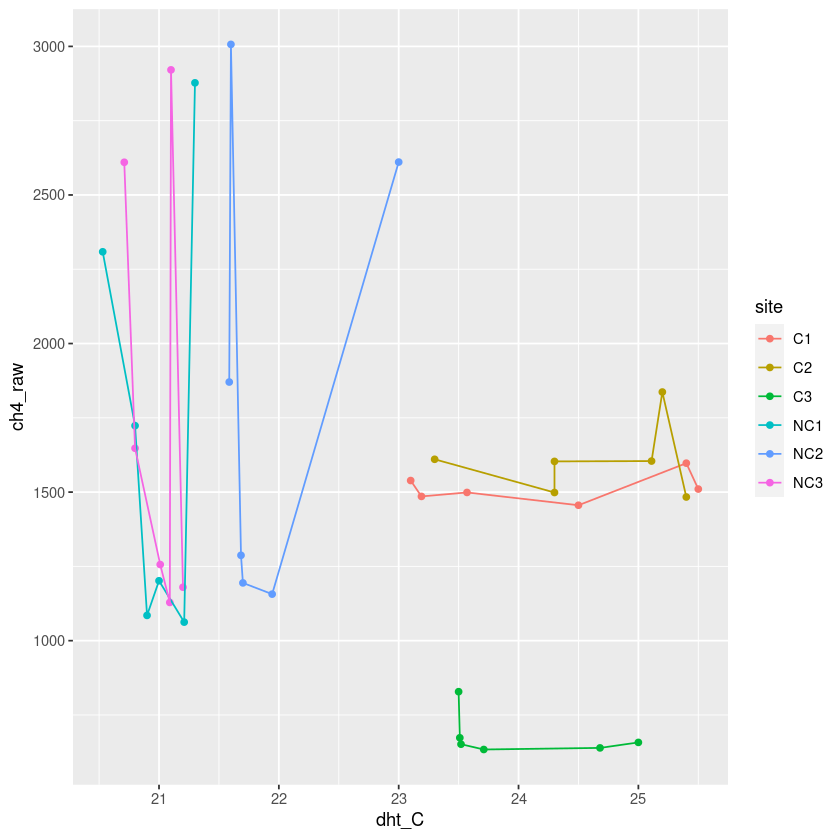

In [30]:
# methane vs humidity
ggplot(last_hour_sM, aes(x=aH_gm3, y=ch4_raw, color=site))+geom_point()+geom_line()

# methane vs temperature
ggplot(last_hour_sM, aes(x=dht_C, y=ch4_raw, color=site))+geom_point()+geom_line()

# Process GC calibration curve and data

In [33]:
directory
GC_dir<-paste(directory,"/GC",sep="")
dir.exists(GC_dir)

[1] "~/Desktop/data/Methane Calibration/concentration_tests"

[1] TRUE

In [36]:
rm(GC_raw_file)

In [37]:
exDirectory
GC_dir<-paste(exDirectory,"/GC",sep="")
dir.exists(GC_dir)

[1] "~/Desktop/data/Methane Calibration/concentration_tests/20230309_1000ppm_"

[1] TRUE

In [43]:
GC_raw_file<-paste(GC_dir,"/",list.files(GC_dir, recursive=TRUE), sep="")
GC_raw_file
file.exists(GC_raw_file)

[1] "~/Desktop/data/Methane Calibration/concentration_tests/20230309_1000ppm_/GC/raw/20230310_CH4_GC.csv"

[1] TRUE

In [30]:
GC_raw_file<-paste(GC_dir,"/raw/",list.files(GC_dir), sep="")
GC_raw_file
# file.exists(GC_raw_file)

[1] "~/Desktop/data/Methane Calibration/concentration_tests/20230309_1000ppm_/GC/raw/raw"

In [44]:
GC_data<-read.csv(file=GC_raw_file, header=TRUE)
head(GC_data)

,Data.,Data.Filename,Sample.Type,Level.,Ret..Time,Area,Height,Conc...ppm.,Std..Conc.,Area.,Height.,Accuracy...,Cal..Point,Known,DateRun
,<int>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>
1,1,1090127_3102023_001.gcd,Unknown,0,2.871,14739,1818,2.246,-----,10.004,16.519,-----,-----,NA,20230310
2,2,2090128_3102023_002.gcd,Unknown,0,2.866,15004,1939,2.287,-----,19.295,29.936,-----,-----,NA,20230310
3,3,3090128_3102023_003.gcd,Unknown,0,2.871,18168,2063,2.769,-----,17.668,24.766,-----,-----,NA,20230310
4,4,4090129_3102023_004.gcd,Unknown,0,2.872,14689,1860,2.239,-----,14.664,23.596,-----,-----,NA,20230310
5,5,5090130_3102023_005.gcd,Unknown,0,2.874,15312,1911,2.334,-----,11.922,19.858,-----,-----,NA,20230310
6,6,6090130_3102023_006.gcd,Unknown,0,2.882,15305,1906,2.332,-----,14.856,23.381,-----,-----,NA,20230310


In [115]:
str(GC_data)

'data.frame':	38 obs. of  14 variables:
 $ Data.        : int  1 2 3 4 5 6 1 2 3 4 ...
 $ Data.Filename: chr  "N2_R3.gcd" "10ppm_CH4_R1.gcd" "100ppm_CH4_R1.gcd" "1000ppm_CH4_R1.gcd" ...
 $ Sample.Type  : chr  "Unknown" "Unknown" "Unknown" "Unknown" ...
 $ Level.       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Ret..Time    : num  NA 2.85 2.83 2.83 2.87 ...
 $ Known        : int  0 10 100 1000 NA NA 0 NA NA NA ...
 $ Area         : int  NA 51328 497494 3795199 40144 38517 37377913 46333 34303 33081 ...
 $ Height       : int  NA 5314 55288 435730 4335 4216 4236456 5181 3927 3697 ...
 $ Conc...ppm.  : num  NA 8 76 578 6 ...
 $ Std..Conc.   : logi  NA NA NA NA NA NA ...
 $ Area.        : num  NA 15.7 65.1 92.2 11.6 ...
 $ Height.      : num  NA 23.5 78.3 96.3 18.3 ...
 $ Accuracy...  : logi  NA NA NA NA NA NA ...
 $ Cal..Point   : logi  NA NA NA NA NA NA ...


In [46]:
cols<-names(GC_data)
cols

[1] "Data."         "Data.Filename" "Sample.Type"   "Level."       
 [5] "Ret..Time"     "Area"          "Height"        "Conc...ppm."  
 [9] "Std..Conc."    "Area."         "Height."       "Accuracy..."  
[13] "Cal..Point"    "Known"         "DateRun"

In [47]:
GC_curve_data<-GC_data[!is.na(GC_data$Known) & GC_data$Area<6000000,]
GC_curve_data

# ggplot(GC_curve_data,aes(x=Area, y=Known))+geom_point()+stat_smooth(method="lm")

GC_curve<-lm(formula=Known~Area, data=GC_curve_data)
GC_curve

,Data.,Data.Filename,Sample.Type,Level.,Ret..Time,Area,Height,Conc...ppm.,Std..Conc.,Area.,Height.,Accuracy...,Cal..Point,Known,DateRun
,<int>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>
7,7,1000_CH4_1_3102023_007.gcd,Unknown,0,2.829,3741160,427685,570.159,-----,92.134,96.198,-----,-----,1000,20230310
14,14,N2_1_3102023_014.gcd,Unknown,0,2.869,22155,2609,3.376,-----,8.273,14.472,-----,-----,0,20230310
15,15,N2_2_3102023_015.gcd,Unknown,0,2.866,25437,2780,3.877,-----,8.330,13.348,-----,-----,0,20230310
22,22,1000_CH4_2_3102023_022.gcd,Unknown,0,2.829,4199835,481181,640.062,-----,92.128,96.038,-----,-----,1000,20230310
23,23,N2 BLANK_20230309_CH4_CURVE_392023_1430 PM_001.gcd,Unknown,0,2.850,3818,484,0.582,-----,1.251,3.419,-----,-----,0,20230309
24,24,N2 BLANK_20230309_CH4_CURVE_392023_1430 PM_002.gcd,Unknown,0,2.867,7169,982,1.093,-----,33.641,39.136,-----,-----,0,20230309
25,25,1PPM CH4_20230309_CH4_CURVE_392023_1430 PM_003.gcd,Unknown,0,2.838,46907,5194,7.149,-----,27.279,41.957,-----,-----,1,20230309
26,26,1PPM CH4_20230309_CH4_CURVE_392023_1430 PM_004.gcd,Unknown,0,2.844,58369,6024,8.896,-----,24.589,32.507,-----,-----,1,20230309
27,27,5PPM CH4_20230309_CH4_CURVE_392023_1430 PM_005.gcd,Unknown,0,2.845,44550,4799,6.789,-----,41.579,50.394,-----,-----,5,20230309



Call:
lm(formula = Known ~ Area, data = GC_curve_data)

Coefficients:
(Intercept)         Area  
  0.1944600    0.0002416  


In [48]:
print(GC_curve)

intercept<-GC_curve$coefficients[1]
slope<-GC_curve$coefficients[2]

intercept
slope


Call:
lm(formula = Known ~ Area, data = GC_curve_data)

Coefficients:
(Intercept)         Area  
  0.1944600    0.0002416  



(Intercept) 
    0.19446

Area 
0.0002415647

In [49]:
# GC_data$cal=0.0002452*GC_data$Area+-9.0788829
GC_data$cal=slope*GC_data$Area+intercept
GC_data

Data.,Data.Filename,Sample.Type,Level.,Ret..Time,Area,Height,Conc...ppm.,Std..Conc.,Area.,Height.,Accuracy...,Cal..Point,Known,DateRun,cal
<int>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<dbl>
1,1090127_3102023_001.gcd,Unknown,0,2.871,14739,1818,2.246,-----,10.004,16.519,-----,-----,NA,20230310,3.754882
2,2090128_3102023_002.gcd,Unknown,0,2.866,15004,1939,2.287,-----,19.295,29.936,-----,-----,NA,20230310,3.818897
3,3090128_3102023_003.gcd,Unknown,0,2.871,18168,2063,2.769,-----,17.668,24.766,-----,-----,NA,20230310,4.583208
4,4090129_3102023_004.gcd,Unknown,0,2.872,14689,1860,2.239,-----,14.664,23.596,-----,-----,NA,20230310,3.742804
5,5090130_3102023_005.gcd,Unknown,0,2.874,15312,1911,2.334,-----,11.922,19.858,-----,-----,NA,20230310,3.893299
6,6090130_3102023_006.gcd,Unknown,0,2.882,15305,1906,2.332,-----,14.856,23.381,-----,-----,NA,20230310,3.891608
7,1000_CH4_1_3102023_007.gcd,Unknown,0,2.829,3741160,427685,570.159,-----,92.134,96.198,-----,-----,1000,20230310,903.926747
8,1090227_3102023_008.gcd,Unknown,0,2.832,6045042,677309,921.275,-----,93.809,96.640,-----,-----,NA,20230310,1460.463370
9,2090228_3102023_009.gcd,Unknown,0,2.827,6936094,792391,1057.070,-----,94.590,97.477,-----,-----,NA,20230310,1675.710101


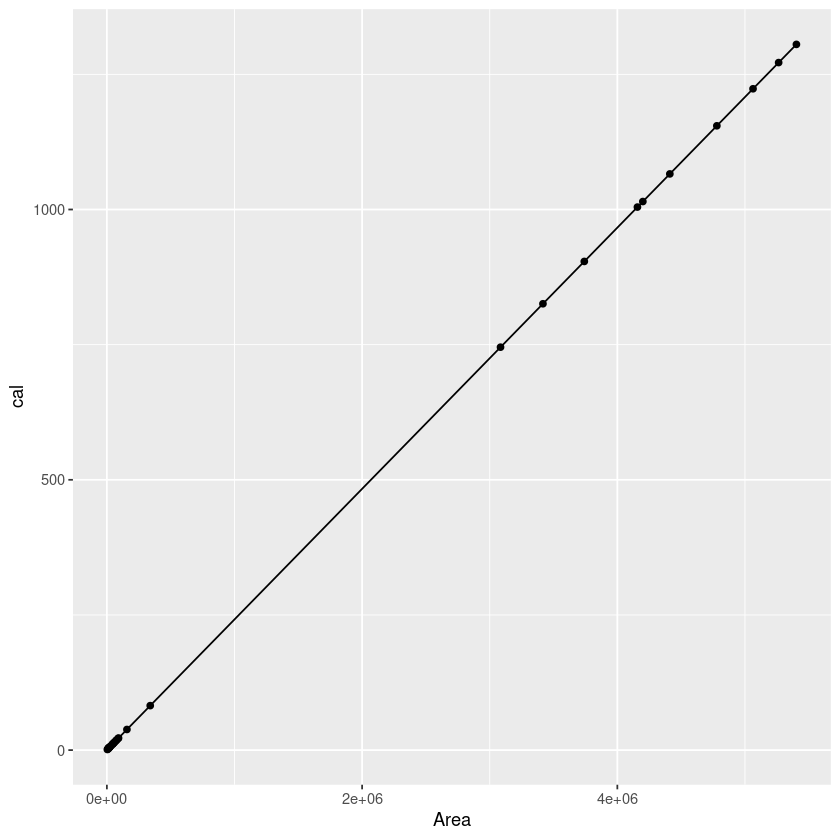

In [53]:
GC_data_clean<-GC_data[GC_data$Area<6000000,]
ggplot(GC_data_clean,aes(x=Area,y=cal))+geom_point()+geom_line()
saveDFcsv(GC_data_clean, od=paste(directory,"/",sep=""))

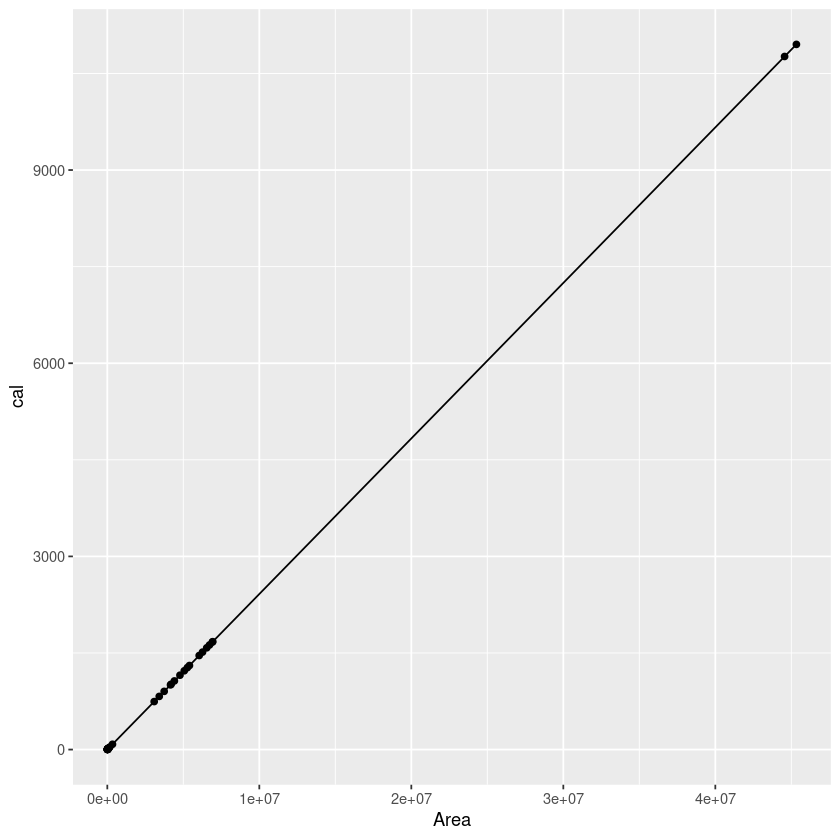

In [55]:
ggplot(GC_data,aes(x=Area,y=cal))+geom_point()+geom_line()
saveDFcsv(GC_data, od=paste(exDirectory,"/",sep=""))

# Process 2023-03-21 GC results

In [12]:
gcFile<-"~/Desktop/data/Methane Calibration/field_test/20230317_deployment/GC/20230321_GC.csv"
gcData<-read.csv(file=gcFile, header=TRUE)

In [13]:
gcData$Area<-as.numeric( gsub(",","",gcData$Area) ) # gsub to remove commas
gcData$Known<-as.numeric(gcData$Known)

In [14]:
gcCurveData<-gcData[!is.na(gcData$Known),]
gcCurveData

,Data.,Data.Filename,Sample.Type,Level.,Ret..Time,Area,Height,Conc...ppm.,Std..Conc.,Area.,Height.,Accuracy...,Cal..Point,Known
,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,1,N2_1_3212023_001.gcd,Unknown,0,2.860,9759,"1,458",1.487,-----,7.612,19.223,-----,-----,0
2,2,N2_2_3212023_002.gcd,Unknown,0,2.874,18534,"2,238",2.825,-----,72.649,72.648,-----,-----,0
3,3,N2_3_3212023_003.gcd,Unknown,0,2.878,16601,"2,104",2.53,-----,64.832,70.174,-----,-----,0
4,4,1_CH4_1_3212023_004.gcd,Unknown,0,2.871,24179,"2,740",3.685,-----,16.106,23.865,-----,-----,1
5,5,1_CH4_2_3212023_005.gcd,Unknown,0,2.872,27336,"3,110",4.166,-----,26.531,37.762,-----,-----,1
6,6,5_CH4_1_3212023_006.gcd,Unknown,0,2.862,37824,"4,331",5.764,-----,29.004,40.456,-----,-----,5
7,7,5_CH4_2_3212023_007.gcd,Unknown,0,2.863,36449,"3,880",5.555,-----,28.898,39.092,-----,-----,5
8,8,10_CH4_1_3212023_008.gcd,Unknown,0,2.852,58789,"6,451",8.96,-----,49.840,63.747,-----,-----,10
9,9,10_CH4_2_3212023_009.gcd,Unknown,0,2.855,62369,"6,560",9.505,-----,53.066,65.124,-----,-----,10


In [15]:
gcCurve<-lm(formula=Known~Area, data=gcCurveData)
summary(gcCurve)


Call:
lm(formula = Known ~ Area, data = gcCurveData)

Residuals:
    Min      1Q  Median      3Q     Max 
-391.32   -1.30   -0.40    1.32  434.21 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.411e+00  2.706e+01  -0.126    0.901    
Area         2.061e-04  1.923e-06 107.172   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 125.5 on 22 degrees of freedom
Multiple R-squared:  0.9981,	Adjusted R-squared:  0.998 
F-statistic: 1.149e+04 on 1 and 22 DF,  p-value: < 2.2e-16


In [16]:
intercept<-gcCurve$coefficients[1]
slope<-gcCurve$coefficients[2]

intercept
slope

(Intercept) 
  -3.411293

Area 
0.0002060851

In [17]:
gcData$cal=slope*gcData$Area+intercept
gcData

Data.,Data.Filename,Sample.Type,Level.,Ret..Time,Area,Height,Conc...ppm.,Std..Conc.,Area.,Height.,Accuracy...,Cal..Point,Known,cal
<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,N2_1_3212023_001.gcd,Unknown,0,2.860,9759,"1,458",1.487,-----,7.612,19.223,-----,-----,0,-1.400109e+00
2,N2_2_3212023_002.gcd,Unknown,0,2.874,18534,"2,238",2.825,-----,72.649,72.648,-----,-----,0,4.082878e-01
3,N2_3_3212023_003.gcd,Unknown,0,2.878,16601,"2,104",2.53,-----,64.832,70.174,-----,-----,0,9.925326e-03
4,1_CH4_1_3212023_004.gcd,Unknown,0,2.871,24179,"2,740",3.685,-----,16.106,23.865,-----,-----,1,1.571638e+00
5,1_CH4_2_3212023_005.gcd,Unknown,0,2.872,27336,"3,110",4.166,-----,26.531,37.762,-----,-----,1,2.222249e+00
6,5_CH4_1_3212023_006.gcd,Unknown,0,2.862,37824,"4,331",5.764,-----,29.004,40.456,-----,-----,5,4.383669e+00
7,5_CH4_2_3212023_007.gcd,Unknown,0,2.863,36449,"3,880",5.555,-----,28.898,39.092,-----,-----,5,4.100302e+00
8,10_CH4_1_3212023_008.gcd,Unknown,0,2.852,58789,"6,451",8.96,-----,49.840,63.747,-----,-----,10,8.704242e+00
9,10_CH4_2_3212023_009.gcd,Unknown,0,2.855,62369,"6,560",9.505,-----,53.066,65.124,-----,-----,10,9.442027e+00


[1] "~/Desktop/data/Methane Calibration/field_test/20230317_deployment/GC/gcData_processed.csv"


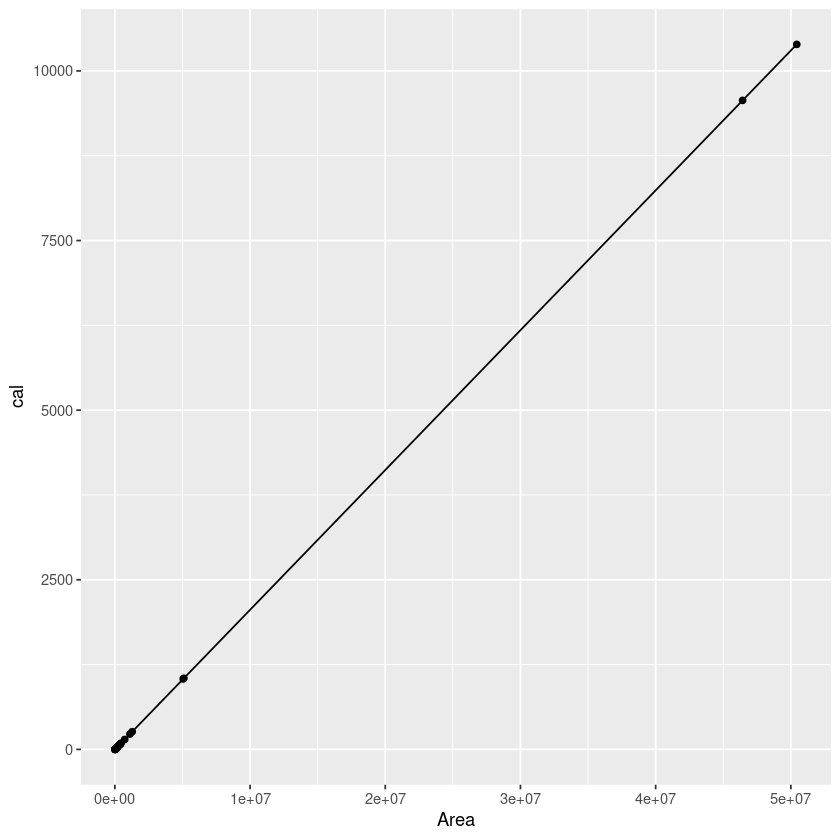

In [25]:
gcDir<-"~/Desktop/data/Methane Calibration/field_test/20230317_deployment/GC"
ggplot(gcData,aes(x=Area,y=cal))+geom_point()+geom_line()
saveDFcsv(gcData, tag="processed", od=paste(gcDir,"/",sep=""))

# Work with GC Calibration Sample Log

In [141]:
sampleLogPath<-"~/Desktop/data/Methane Calibration/concentration_tests/GC/GC Calibration Sample Log.csv"

In [156]:
calLog<-read.csv(sampleLogPath)

In [157]:
str(calLog)

'data.frame':	36 obs. of  12 variables:
 $ Sample.ID         : chr  "CH001.gcd" "CH002.gcd" "CH003.gcd" "CH004.gcd" ...
 $ Sensor.UUID       : chr  "57FF70068387575129270167" "57FF6C068387575136470767" "50FF6F068678545226521667" "50FF6C068678545210222467" ...
 $ Date.Collected    : chr  "2023-02-21" "2023-02-21" "2023-02-21" "2023-02-21" ...
 $ Time.Collected    : chr  "12:03" "12:04" "12:05" "12:06" ...
 $ target.ch4.ppm    : int  1000 1000 1000 1000 1000 1000 100 100 100 100 ...
 $ volume..mL.       : int  810 810 810 920 920 920 810 810 810 920 ...
 $ mL.injected       : num  1 1 1 1 1 1 0.1 0.1 0.1 0.1 ...
 $ CH4.injected..ppm.: int  1000000 1000000 1000000 1000000 1000000 1000000 1000000 1000000 1000000 1000000 ...
 $ calculated.ppm    : int  1235 1235 1235 1087 1087 1087 123 123 123 109 ...
 $ gc.ch4.ppm        : num  959 1080 636 645 627 ...
 $ Date.Run          : chr  "2023-02-21" "2023-02-21" "2023-02-21" "2023-02-21" ...
 $ Sensor            : chr  "CH001" "CH002" "CH003" "CH

In [158]:
# paste(calLog$Date.Collected[1],calLog$Time.Collected, sep=" ")
calLog$datetime<-paste(calLog$Date.Collected,calLog$Time.Collected, sep=" ")
calLog$datetime<-lubridate::as_datetime(calLog$datetime,tz="EST",format="%Y-%m-%d %H:%M")
calLog$datetime

 [1] "2023-02-21 12:03:00 EST" "2023-02-21 12:04:00 EST"
 [3] "2023-02-21 12:05:00 EST" "2023-02-21 12:06:00 EST"
 [5] "2023-02-21 12:08:00 EST" "2023-02-21 12:09:00 EST"
 [7] "2023-02-22 13:14:00 EST" "2023-02-22 13:15:00 EST"
 [9] "2023-02-22 13:16:00 EST" "2023-02-22 13:17:00 EST"
[11] "2023-02-22 13:18:00 EST" "2023-02-22 13:19:00 EST"
[13] "2023-02-23 09:52:00 EST" "2023-02-23 09:53:00 EST"
[15] "2023-02-23 09:54:00 EST" "2023-02-23 09:54:00 EST"
[17] "2023-02-23 09:56:00 EST" "2023-02-23 09:57:00 EST"
[19] "2023-02-24 11:21:00 EST" "2023-02-24 11:22:00 EST"
[21] "2023-02-24 11:23:00 EST" "2023-02-24 11:24:00 EST"
[23] "2023-02-24 11:25:00 EST" "2023-02-24 11:26:00 EST"
[25] "2023-02-25 11:44:00 EST" "2023-02-25 11:45:00 EST"
[27] "2023-02-25 11:45:00 EST" "2023-02-25 11:46:00 EST"
[29] "2023-02-25 11:47:00 EST" "2023-02-25 11:47:00 EST"
[31] "2023-02-27 11:00:00 EST" "2023-02-27 11:01:00 EST"
[33] "2023-02-27 11:02:00 EST" "2023-02-27 11:02:00 EST"
[35] "2023-02-27 11:03:00 EST" 

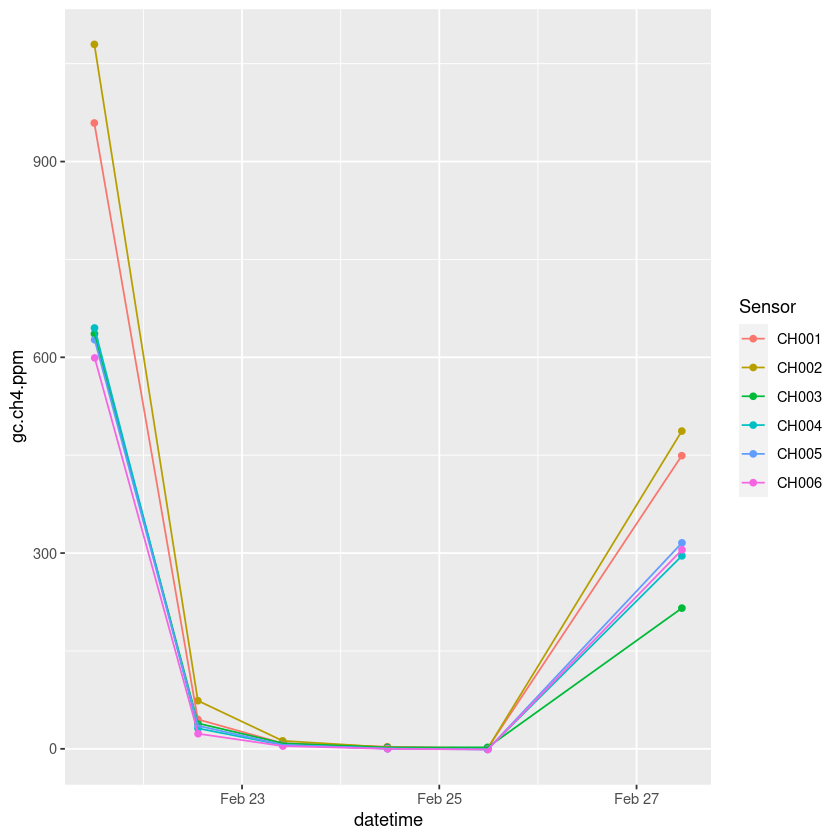

In [159]:
ggplot(calLog, aes(x=datetime, y=gc.ch4.ppm, color=Sensor))+geom_point()+geom_line()